# Assignment 1: Deadline: first class in week 4 of the course: 25-2-2025 10:00 (if updated).
Hand in this notebook with output. Make sure that it is able to run and produce all the figures and results you show. Also, use the text boxes to answer the questions and interpret your results, relating them to the course materials.


Exercises made by Oliver Gurney-Champion. Please contact us via Canvas, or e-mail directly to:
Oliver: o.j.gurney-champion@amsterdamumc.nl
Matthan: m.w.a.caan@amsterdamumc.nl
Dilara: d.tank@amsterdamumc.nl
Daan: d.kuppens@amsterdamumc.nl

These are a large set of challenging exercises, for which you will get 3 weeks to complete. I would strongly advise you to stick to the suggested schedule, which will ensure you have sufficient knowledge to answer the questions when completing them, and finalize all questions in time.

Note that the networks will be lite and can run on your local computer/laptop in short time (minutes). There is no need as yet to run this on Surf, although we highly encourage you to make sure Surf works for you (for exercise sets 2 and 3).

# Exercise 1: Program network in PyTorch. (60%)
During the class, a brief introduction was given to quantitative imaging. In this exercise, you will program your first neural network that will help estimate quantitative MRI parameters from quantitative data. In particular, we will be looking at the intra-voxel incoherent motion (IVIM) model for diffusion-weighted MRI:

S(b)=S_0×( (1-f)×e^-b×D^ +f×e^-b×D*^ )                                                                    [1]

With S the measured signal, S0 the baseline signal at S(b=0), f the perfusion fraction, D the diffusion coefficient and D* the pseudo diffusion coefficient. For more information on what the model means exactly and how it is used clinically, I would suggest reading "Introduction to IVIM MRI | Radiology Key" (https://radiologykey.com/introduction-to-ivim-mri/). But for the purpose of this exercise, it is just a model.

Normally, f, D and D* (named Dp in the code) are obtained by fitting S(b) using least-squares fitting. But these approaches are known to be prone to noise in the data and often produce poor estimates.

Therefore, you will write a neural network that predicts f from a given S(b). There are great tools available that take care of training models, such as PyTorch, Karas and Tensorflow. However, for the purpose of this exercise, you will make use of PyTorch. Moreover, we will use weights-and-biasses to keep track of how training is going.

# Wednesday 3-4-2024
At https://github.com/oliverchampion/AI_for_medical_imaging_course you will find the Python assignment. To help visualize progress and to isolate certain snippets of code, we wrote this as a Jupyter Notebook (exercise1.ipynb). As you can see, we have already provided a data-generator, some plotting tools to plot the training progress. The notebook should run as is and train a neural network! For your first lecture, we suggest you (Wednesday)
-	Install all prerequisites in your virtual enviroment (requierements.txt)
-	Start a WandB account @ https://wandb.ai/  you will need to log in when running the script
-	Go through the script to see whether you understand what happens.
-	Train your first neural network .
-	Visualize the results on your WandB page.

## Import requiered packages
imports the packages and sets the random seed

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import random
import numpy as np
import torch
import helper_functions as hf
import os
import torch.nn as nn
from matplotlib import pyplot as plt
from matplotlib import colormaps

# set random seed
seed =42

login to your free wandb account. Note you will need to set up your account on https://wandb.ai/authorize
wandb allows you to keep track of your neural network training.

In [2]:
import wandb
os.environ["WANDB_SILENT"] = "true"
%env WANDB_SILENT=True
wandb.login()

env: WANDB_SILENT=True


True

## Simulate and view the IVIM data
This allows you to study what the data looks like in jupyter.

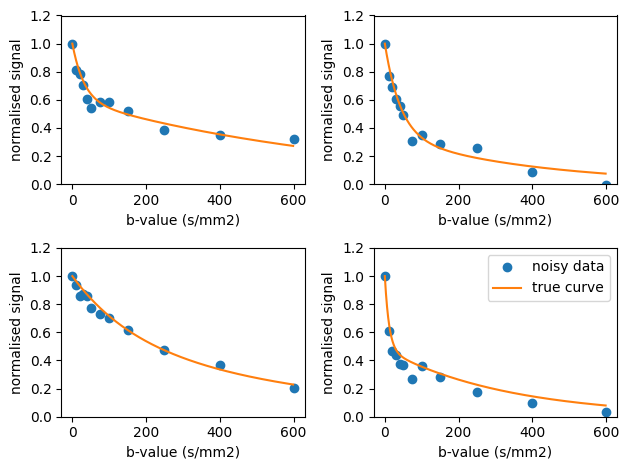

In [56]:
# set b-values at which we "measure" (i.e. simulate signal)
bvalues=[0, 10, 20, 30, 40, 50, 75, 100, 150, 250, 400, 600]

## Set the random seeds for reproducibility
np.random.seed(seed)
random.seed(seed)

## Loading the (simulated) dataset
data_sim, D, f, Dp = hf.sim_signal(SNR=(10,30),bvalues=bvalues,sims=30,seed=np.random.randint(1,10000))

## plotting some curves and data for visualisation
fig, axs = plt.subplots(2, 2)
for i in range(2):
    for j in range(2):
        axs[i, j].plot(bvalues, data_sim[i+10*j,:], 'o')
        datapred=hf.ivim(np.arange(0,np.max(bvalues)), D[i+10*j], f[i+10*j], Dp[i+10*j], 1)
        axs[i, j].plot(np.arange(0,np.max(bvalues)), datapred)
        axs[i, j].set_ylim(0, 1.2)
        axs[i, j].set(xlabel='b-value (s/mm2)', ylabel='normalised signal')
plt.legend(('noisy data', 'true curve'))
plt.tight_layout()

## Splitting the data into training and validation
Here, we split our data into a training set, validation set and test set. Note that the current implementation only uses the training set and it is up to you (in your exercises) to also implement the validation and test run. At this point, we already split the data for you.

In [4]:
def sim_dat(bvalues,batch_size = 16,SNR=(10,40),sims=1000,seed=69):   #removed the seed randomisation      np.random.randint(1,10000)):
    with wandb.init(project="AI_for_medical_imaging", job_type="visualize data") as run:
        data_sim = hf.sim_signal(SNR=SNR,bvalues=bvalues,sims=sims,seed=seed)
        # Only for visualisation purposes: here we create our "Artifact" in wandb --> this allows viewing the data in your wandb account
        for i in range(4):
            #make b-value data pairs
            example_data=[[x,y] for (x,y) in zip(bvalues,data_sim[0][i])]
            # put it in a table
            table = wandb.Table(data=example_data, columns=["b-values", "signal"])
            #tell wandb to plot the table
            wandb.log({"data_plot " + str(i): wandb.plot.scatter(table, "b-values", "signal")})

        # here we split the data into train (70%), test (15%) and validation (15%) sets
        #split = int(np.floor(len(data_sim[0]) * 0.7))
        train_set, test_set, val_set = torch.utils.data.random_split([[data_sim[0][i,:],data_sim[1][i],data_sim[2][i],data_sim[3][i]] for i in range(len(data_sim[3]))],[0.7,0.15,0.15])
        #split = int(np.floor(len(rest) * 0.5))
        #test_set, val_set = torch.utils.data.random_split([[rest[0][i,:],rest[1][i],rest[2][i],rest[3][i]] for i in range(len(rest[3]))],[split, len(rest[0]) - split])

        # train loader loads the trianing data. We want to shuffle to make sure data order is modified each epoch and different data is selected each epoch.
        trainloader = torch.utils.data.DataLoader(train_set,
                                       batch_size=batch_size,
                                       shuffle=True,
                                       drop_last=True)
        # validation data is loaded here. By not shuffling, we make sure the same data is loaded for validation every time. We can use substantially more data per batch as we are not training.
        inferloader = torch.utils.data.DataLoader(val_set,
                                       batch_size=min(batch_size,len(val_set)),
                                       shuffle=False,
                                       drop_last=False)
            # validation data is loaded here. By not shuffling, we make sure the same data is loaded for validation every time. We can use substantially more data per batch as we are not training.
        testloader = torch.utils.data.DataLoader(test_set,
                                       batch_size=min(batch_size,len(test_set)),
                                       shuffle=False,
                                       drop_last=False)
    return trainloader, inferloader, testloader
sim_dat(bvalues)

(<torch.utils.data.dataloader.DataLoader at 0x219a6b82a90>,
 <torch.utils.data.dataloader.DataLoader at 0x219a6812c10>)

In [ ]:
def sim_dat_means(trainloader):
    f_mean = []
    D_mean = []
    Dp_mean = []
    
    for x in trainloader:
        D_mean.append(torch.mean(x[1]))
        f_mean.append(torch.mean(x[2]))
        Dp_mean.append(torch.mean(x[3]))

    D_mean = np.mean(D_mean)
    f_mean = np.mean(f_mean)
    Dp_mean = np.mean(Dp_mean)

    return D_mean, f_mean, Dp_mean


## Design a neural network

In [7]:
# function for stacking the layers and making the model
def make_model(n_inputs=5,n_hidden=1, hidden_width=5, n_outputs=1, activation_function='relu', output_scaling=False):
    #initialize the model object
    model = nn.Sequential()
    # add first hidden layer
    model.add_module('first_layer', nn.Linear(n_inputs, hidden_width))

    if activation_function == 'relu':
        # add ReLu layer
        model.add_module('first_ReLu', nn.ReLU())
        # fill out the model with hidden layers.
        for i in range(1, n_hidden):
            # as we loop, we add hidden layers
            model.add_module('layer_linear'+str(i), nn.Linear(hidden_width, hidden_width))
            # we also add a ReLu layer
            model.add_module('layer_ReLu'+str(i), nn.ReLU())
            
    elif activation_function == 'sigmoid':
        # add Sigmoid layer
        model.add_module('first_Sigmoid', nn.Sigmoid())
        # fill out the model with hidden layers.
        for i in range(1, n_hidden):
            # as we loop, we add hidden layers
            model.add_module('layer_linear'+str(i), nn.Linear(hidden_width, hidden_width))
            # we also add a Sigmoid layer
            model.add_module('layer_Sigmoid'+str(i), nn.Sigmoid())

    elif activation_function == 'elu':
        # add ELU layer
        model.add_module('first_ELU', nn.ELU())
        # fill out the model with hidden layers.
        for i in range(1, n_hidden):
            # as we loop, we add hidden layers
            model.add_module('layer_linear'+str(i), nn.Linear(hidden_width, hidden_width))
            # we also add a ELU layer
            model.add_module('layer_ELU'+str(i), nn.ELU())
    
    #and a final output layer
    model.add_module('last_layer',nn.Linear(hidden_width, n_outputs))
    # to ensure positive predictions, we end with a ReLu function before giving output
    model.add_module('last',nn.Sigmoid())
        
    model.apply(init_weights)
    return model

# function for initializing network weights for individual layers
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)

## Train your first network

In [ ]:
def train_network(name, epochs=200, learningrate=0.1, hidden_layers=2, hidden_width=5, seed=42, optimizer='SGD', bvalues=bvalues, batch_size=16, sims=1000, sim_seed=69, activation_function='relu', do_D_Dp=False, output_scaling=False, wandb_interval=10, loss_handling='total weighted', return_model=False, training_data=None, validation_data=None):


    # get the data
    if training_data is None:
        trainloader, inferloader, testloader = sim_dat(bvalues, batch_size=batch_size, sims=sims, seed=sim_seed)
    else:
        trainloader = torch.utils.data.DataLoader(training_data,
                                batch_size=batch_size,
                                shuffle=True,
                                drop_last=True)
        inferloader = torch.utils.data.DataLoader(validation_data,
                                batch_size=min(batch_size,len(validation_data)),
                                shuffle=False,
                                drop_last=False)


    # get the model
    if do_D_Dp:
        model = make_model(n_inputs=len(bvalues), n_hidden=hidden_layers, hidden_width=hidden_width, n_outputs=3, activation_function=activation_function)
        D_mean, f_mean, Dp_mean = sim_dat_means(trainloader)
    else:    
        model = make_model(n_inputs=len(bvalues), n_hidden=hidden_layers, hidden_width=hidden_width, n_outputs=1, activation_function=activation_function)

    # initialize model --> we did this above, but during the exercise, you might be re-running this part of the script several times with different settings. This way we make sure you re-initiate the training and don't continue in the last model
    model.apply(init_weights)

    # initialize wandb
    wandb.init(project="AI_for_medical_imaging", job_type="training", name=name)

    # set random seed for reproducibility
    torch.manual_seed(seed)

    # probe available devices
    if torch.cuda.is_available():  # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Set default device. If GPU is available, the network will be trained on the GPU. Note that further down in the code, stuff will be sent ".to(device)" to make sure it is available on the GPU.
    device = torch.device('cpu')#'cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # define the loss of the network (mean square error)
    loss_module = nn.MSELoss(reduction='mean').to(device)

    # the optimizer determines how strongly to update the network's weights based on the calculated loss.
    if optimizer == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learningrate)
    elif optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learningrate)
    elif optimizer == 'adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=learningrate)
    else:
        raise NotImplementedError('this optimizer is not implemented yet...')

    # initialize the plot data
    plot_data = {
        "train_loss": [],
        "val_loss": [],
        "SD_train": [],
        "SD_val": [],
        "sys_train": [],
        "sys_val": [],
        "SD_val_D": [],
        "sys_val_D": [],
        "SD_train_D": [],	
        "sys_train_D": [],
        "SD_train_Dp": [],
        "sys_train_Dp": [],
        "SD_val_Dp": [],
        "sys_val_Dp": [],
        "train_loss_D": [],
        "val_loss_D": [],
        "train_loss_Dp": [],
        "val_loss_Dp": [],
        "table_train_f": [],
        "table_val_f": [],
        "table_train_D": [],
        "table_val_D": [],
        "table_train_Dp": [],
        "table_val_Dp": []
    }

    # loop over epochs
    for epoch in range(epochs):
        # initiate losses and errors to 0
        train_loss_f = 0
        train_loss_D = 0
        train_loss_Dp = 0
        val_loss_f = 0
        val_loss_D = 0
        val_loss_Dp = 0
        SD_train = 0
        sys_train = 0
        if do_D_Dp:
            SD_train_D = 0
            sys_train_D = 0
            SD_train_Dp = 0
            sys_train_Dp = 0
        
        # set model to training such that forward passes are remembered (requiered for backpropogating the loss)
        model.train()

        # loop over all training data
        for x in trainloader:
            # reset the gradients to zero
            optimizer.zero_grad()
            # get data (x[0]) and put the data on the GPU if available
            batch = x[0].to(device)

            # get the reference f (x[2]) --> note x[1] and x[3] are D and Dp respectively
            f_ref = torch.flatten(x[2].to(device))
            if do_D_Dp:
                D_ref = torch.flatten(x[1].to(device))
                Dp_ref = torch.flatten(x[3].to(device))

            # put the data through the neural network
            if do_D_Dp:
                f_pred, D_pred, Dp_pred = model.forward(batch).T
                if output_scaling: f_pred, D_pred, Dp_pred = f_pred, D_pred*3e-3+0.5e-3, Dp_pred*125e-3+5e-3
            else:
                f_pred = torch.flatten(model.forward(batch))

            # calculate loss (compare predicted f to the ground trueth)
            loss_f = loss_module(f_pred, f_ref)
            if do_D_Dp:
                loss_D = loss_module(D_pred, D_ref)
                loss_Dp = loss_module(Dp_pred, Dp_ref)

            #add found loss to the train loss, to keep track of the loss this epoch
            train_loss_f += loss_f.item()
            if do_D_Dp:
                train_loss_D += loss_D.item()
                train_loss_Dp += loss_Dp.item()

            # propogate the loss through the network (calculate d_weights/d_loss)
            if do_D_Dp:
                if loss_handling == 'total weighted':
                    total_loss_weighted = loss_f/f_mean + loss_D/D_mean + loss_Dp/Dp_mean
                    total_loss_weighted.backward()
                elif loss_handling == 'total':
                    total_loss = loss_f + loss_D + loss_Dp
                    total_loss.backward()
                elif loss_handling == 'separate':
                    loss_f.backward(retain_graph=True)
                    loss_D.backward(retain_graph=True)
                    loss_Dp.backward()
                elif loss_handling == 'separate weighted':
                    (loss_f/f_mean).backward(retain_graph=True)
                    (loss_D/D_mean).backward(retain_graph=True)
                    (loss_Dp/Dp_mean).backward()
                elif loss_handling == 'separate weighted sq':
                    (loss_f/f_mean**2).backward(retain_graph=True)
                    (loss_D/D_mean**2).backward(retain_graph=True)
                    (loss_Dp/Dp_mean**2).backward()
                else:
                    print('loss_handling not available. Use total, total weighted, separate or separate weighted')
            else:
                loss_f.backward()

            # update all weights according to their derrivatives to the loss.
            optimizer.step()
            # calculate the standard deviation and systematic error on the trianing data
            SD, sys = hf.error_metrics(f_pred.cpu().detach().numpy(), f_ref.cpu().detach().numpy())

            if do_D_Dp:
                SD_D, sys_D = hf.error_metrics(D_pred.cpu().detach().numpy(), D_ref.cpu().detach().numpy())
                SD_Dp, sys_Dp = hf.error_metrics(Dp_pred.cpu().detach().numpy(), Dp_ref.cpu().detach().numpy())

            # add the errors to ultimately calculate their mean over the training data. calculating mean SDs goes via the Root Mean Squares. So add SDs squared
            SD_train += SD**2
            sys_train += sys

            if do_D_Dp:
                SD_train_D += SD_D**2
                sys_train_D += sys_D

                SD_train_Dp += SD_Dp**2
                sys_train_Dp += sys_Dp

        # now divide by the total amount of training data to calculate the mean (sys error) and square of mean (SD).
        SD_train = np.sqrt(SD_train/trainloader.__len__())
        sys_train = sys_train/trainloader.__len__()

        if do_D_Dp:
            SD_train_D = np.sqrt(SD_train_D/trainloader.__len__())
            sys_train_D = sys_train_D/trainloader.__len__()

            SD_train_Dp = np.sqrt(SD_train_Dp/trainloader.__len__())
            sys_train_Dp = sys_train_Dp/trainloader.__len__()


        #make b-value data pairs: Note these currently contain the f_ref and f_pred from the trianing data. You may want to swap to validation data once implemented
        example_data=[[x,y] for (x,y) in zip(f_ref.cpu().detach().numpy(),f_pred.cpu().detach().numpy())]
        if do_D_Dp:
            example_data_D=[[x,y] for (x,y) in zip(D_ref.cpu().detach().numpy(),D_pred.cpu().detach().numpy())]
            example_data_Dp=[[x,y] for (x,y) in zip(Dp_ref.cpu().detach().numpy(),Dp_pred.cpu().detach().numpy())]
        
        # after training, set model to evaluation mode
        model.eval()
        
        if not return_model or return_model == 'all':

            ######################your code here for validation loss#########################

            # initialize error_metrics
            SD_val = 0
            sys_val = 0


            if do_D_Dp:
                SD_val_D = 0
                sys_val_D = 0
                SD_val_Dp = 0
                sys_val_Dp = 0

            for x in inferloader:
                # get data (x[0]) and put the data on the GPU if available
                batch = x[0].to(device)
                # get the reference f (x[2]) --> note x[1] and x[3] are D and Dp respectively
                f_ref = torch.flatten(x[2].to(device))

                if do_D_Dp:
                    D_ref = torch.flatten(x[1].to(device))
                    Dp_ref = torch.flatten(x[3].to(device))

                # put the data through the neural network
                if do_D_Dp:
                    f_pred, D_pred, Dp_pred = model.forward(batch).T
                    if output_scaling: f_pred, D_pred, Dp_pred = f_pred, D_pred*3e-3+0.5e-3, Dp_pred*125e-3+5e-3
                else:
                    f_pred = torch.flatten(model.forward(batch))

                # calculate loss (compare predicted f to the ground trueth)
                loss_f = loss_module(f_pred, f_ref)

                if do_D_Dp:
                    loss_D = loss_module(D_pred, D_ref)
                    loss_Dp = loss_module(Dp_pred, Dp_ref)

                #add found loss to the validation loss, to keep track of the loss this epoch
                val_loss_f += loss_f.item()

                if do_D_Dp:
                    val_loss_D += loss_D.item()
                    val_loss_Dp += loss_Dp.item()

                # calculate the standard deviation and systematic error on the validation data
                SD, sys = hf.error_metrics(f_pred.cpu().detach().numpy(),f_ref.cpu().detach().numpy())

                if do_D_Dp:
                    SD_D, sys_D = hf.error_metrics(D_pred.cpu().detach().numpy(), D_ref.cpu().detach().numpy())
                    SD_Dp, sys_Dp = hf.error_metrics(Dp_pred.cpu().detach().numpy(), Dp_ref.cpu().detach().numpy())

                # add the errors to ultimately calculate their mean over the validation data. calculating mean SDs goes via the Root Mean Squares. So add SDs squared
                SD_val += SD**2
                sys_val += sys

                if do_D_Dp:
                    SD_val_D += SD_D**2
                    sys_val_D += sys_D

                    SD_val_Dp += SD_Dp**2
                    sys_val_Dp += sys_Dp


            #make b-value data pairs: Note these currently contain the f_ref and f_pred from the trianing data. You may want to swap to validation data once implemented
            example_data_val=[[x,y] for (x,y) in zip(f_ref.cpu().detach().numpy(),f_pred.cpu().detach().numpy())]
            
            if do_D_Dp:
                example_data_val_D=[[x,y] for (x,y) in zip(D_ref.cpu().detach().numpy(),D_pred.cpu().detach().numpy())]
                example_data_val_Dp=[[x,y] for (x,y) in zip(Dp_ref.cpu().detach().numpy(),Dp_pred.cpu().detach().numpy())]
            

            # now divide by the total amount of training data to calculate the mean (sys error) and square of mean (SD).
            SD_val = np.sqrt(SD_val/inferloader.__len__())
            sys_val = sys_val/inferloader.__len__()

            if do_D_Dp:
                SD_val_D = np.sqrt(SD_val_D/inferloader.__len__())
                sys_val_D = sys_val_D/inferloader.__len__()

                SD_val_Dp = np.sqrt(SD_val_Dp/inferloader.__len__())
                sys_val_Dp = sys_val_Dp/inferloader.__len__()
            
            # put it in a table
            table = wandb.Table(data=example_data, columns=["f_ref", "f_pred"])
            if do_D_Dp:
                table_D = wandb.Table(data=example_data_D, columns=["D_ref", "D_pred"])
                table_Dp = wandb.Table(data=example_data_Dp, columns=["Dp_ref", "Dp_pred"])

            # tell wandb to plot the table for the validation data
            table_val = wandb.Table(data=example_data_val, columns=["f_ref", "f_pred"])
            if do_D_Dp:
                table_D_val = wandb.Table(data=example_data_val_D, columns=["D_ref", "D_pred"])
                table_Dp_val = wandb.Table(data=example_data_val_Dp, columns=["Dp_ref", "Dp_pred"])

            #tell wandb to plot the table
            # note that some parameters are being logged which you still need to define in the validation loop!
            if epoch % wandb_interval == 0:
                wandb.log({"loss/train": train_loss_f/trainloader.__len__(),
                "loss/val": val_loss_f/inferloader.__len__(),
                "error/random error": SD_train,
                "error/systematic error": sys_train,
                "Training Data (Epoch " + str(epoch) + ")": wandb.plot.scatter(table, "f_ref", "f_pred", title=f'Training Data f (Epoch {epoch})'),
                "Validation Data (Epoch " + str(epoch) + ")": wandb.plot.scatter(table_val, "f_ref", "f_pred", title=f'Validation Data f (Epoch {epoch})')})
                if do_D_Dp:
                    wandb.log({
                        "loss/train_D": train_loss_D/trainloader.__len__(),
                        "loss/val_D": val_loss_D/inferloader.__len__(),
                        "error/random error_D": SD_train_D,
                        "error/systematic error_D": sys_train_D,
                        "Training Data D (Epoch " + str(epoch) + ")": wandb.plot.scatter(table_D, "D_ref", "D_pred", title=f'Training Data D (Epoch {epoch})')
                        })
                    wandb.log({"loss/train_Dp": train_loss_Dp/trainloader.__len__(),
                        "loss/val_Dp": val_loss_Dp/inferloader.__len__(),
                        "error/random error_Dp": SD_train_Dp,
                        "error/systematic error_Dp": sys_train_Dp,
                        "Training Data Dp (Epoch " + str(epoch) + ")": wandb.plot.scatter(table_Dp, "Dp_ref", "Dp_pred", title=f'Training Data Dp (Epoch {epoch})')})
                    
                    wandb.log({
                        "Validation Data D (Epoch " + str(epoch) + ")": wandb.plot.scatter(table_D_val, "D_ref", "D_pred", title=f'Validation Data D (Epoch {epoch})'),
                        "Validation Data Dp (Epoch " + str(epoch) + ")": wandb.plot.scatter(table_Dp_val, "Dp_ref", "Dp_pred", title=f'Validation Data Dp (Epoch {epoch})')})

            # add the data to the plot_data dictionary
            plot_data["train_loss"].append(train_loss_f/trainloader.__len__())
            plot_data["val_loss"].append(val_loss_f/inferloader.__len__())
            plot_data["SD_train"].append(SD_train)
            plot_data["SD_val"].append(SD_val)  
            plot_data["sys_train"].append(sys_train)
            plot_data["sys_val"].append(sys_val)
            plot_data["table_train_f"].append(example_data)
            plot_data["table_val_f"].append(example_data_val)
            if do_D_Dp:
                plot_data["SD_train_D"].append(SD_train_D)
                plot_data["sys_train_D"].append(sys_train_D)
                plot_data["SD_train_Dp"].append(SD_train_Dp)
                plot_data["sys_train_Dp"].append(sys_train_Dp)
                plot_data["SD_val_D"].append(SD_val_D)
                plot_data["sys_val_D"].append(sys_val_D)
                plot_data["SD_val_Dp"].append(SD_val_Dp)
                plot_data["sys_val_Dp"].append(sys_val_Dp)
                plot_data["train_loss_D"].append(train_loss_D/trainloader.__len__())
                plot_data["val_loss_D"].append(val_loss_D/inferloader.__len__())
                plot_data["train_loss_Dp"].append(train_loss_Dp/trainloader.__len__())
                plot_data["val_loss_Dp"].append(val_loss_Dp/inferloader.__len__())
                plot_data["table_train_D"].append(example_data_D)
                plot_data["table_val_D"].append(example_data_val_D)
                plot_data["table_train_Dp"].append(example_data_Dp)
                plot_data["table_val_Dp"].append(example_data_val_Dp)


            ## print output in terminal. Only useful for debugging when WandB does not work
            #print('epoch = ' + str(epoch) + ' train loss =' + str(train_loss_f/trainloader.__len__()) +' val loss =' + str(val_loss_f/inferloader.__len__()) + 'the systematic error is ' + str(sys_val) + ' and the random error is ' + str(SD_val))

    wandb.finish()

    if not return_model or return_model == 'all':
        ######################your code here for testing loss#########################

        # initialize error_metrics
        SD_test=0
        sys_test=0
        test_loss_f=0
        for x in testloader:
            # get data (x[0]) and put the data on the GPU if available
            batch=x[0].to(device)
            # get the reference f (x[2]) --> note x[1] and x[3] are D and Dp respectively
            f_ref = torch.flatten(x[2].to(device))
            # put the data through the neural network
            if do_D_Dp:
                f_pred, D_pred, Dp_pred = model.forward(batch).T
            else:
                f_pred = torch.flatten(model.forward(batch))
            # calculate loss (compare predicted f to the ground trueth)
            loss_f = loss_module(f_pred, f_ref)
            #add found loss to the validation loss, to keep track of the loss this epoch
            test_loss_f += loss_f.item()
            # calculate the standard deviation and systematic error on the validation data
            SD, sys = hf.error_metrics(f_pred.cpu().detach().numpy(),f_ref.cpu().detach().numpy())
            # add the errors to ultimately calculate their mean over the validation data. calculating mean SDs goes via the Root Mean Squares. So add SDs squared
            SD_test += SD**2
            sys_test += sys

        # now divide by the total amount of training data to calculate the mean (sys error) and square of mean (SD).
        SD_test = np.sqrt(SD_test/testloader.__len__())
        sys_test = sys_test/testloader.__len__()
        test_loss = test_loss_f/testloader.__len__()

        return plot_data, SD_test, sys_test, test_loss
    elif return_model == 'all':
        return plot_data, model
    else:
        return model

The following plots show how much the loss curves during training change with different seeds. This effect is very large and will overshadow many of the other effects discussed here. Additionally the validation loss is sometimes higher and sometimes lower than the testing loss, even in late stages of training. This is very uninuitive and could be caused by small datasets, where one dataset gives lower losses for the treaversed parameter space. This was tested by increasing the amount of simulations, which reduced the magnitude of the difference, but did not eleviate the artifact.

The seed was fixed for all following plots for reproducability. Changes did still occur sometimes, which means there is likely still an unseeded random variable.

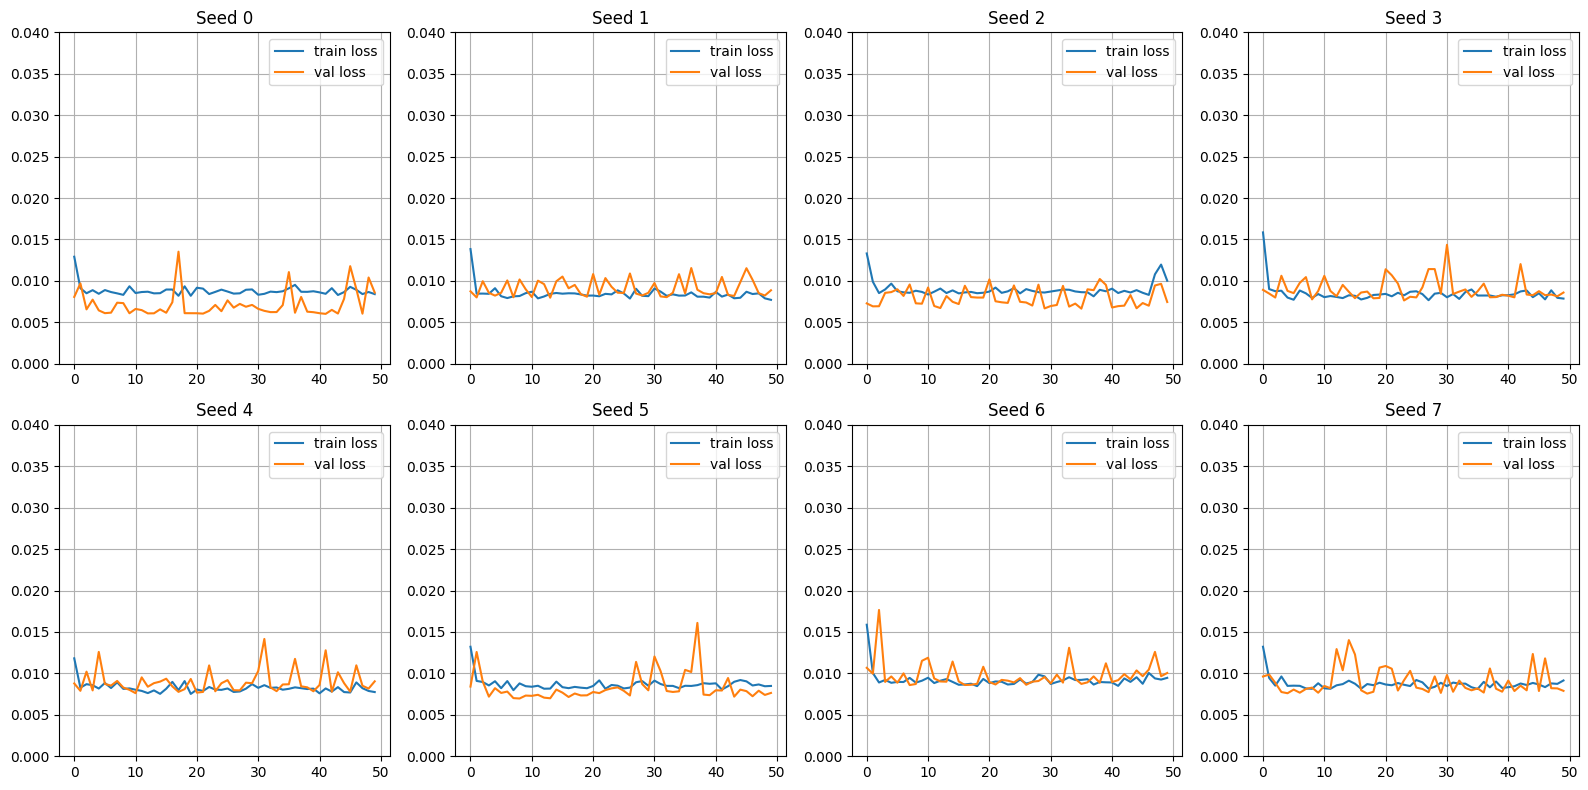

In [8]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for i in range(8):
    plot_data, SD_test, sys_test, test_loss = train_network('test', optimizer='adam', sim_seed=np.random.seed(500), epochs=50, sims=5000)

    row = i // 4
    col = i % 4
    axs[row, col].plot(plot_data["train_loss"], label='train loss')
    axs[row, col].plot(plot_data["val_loss"], label='val loss')
    axs[row, col].legend()
    axs[row, col].grid()
    axs[row, col].set_title(f'Seed {i}')
    axs[row, col].set_ylim(0, 0.04)

fig.tight_layout()

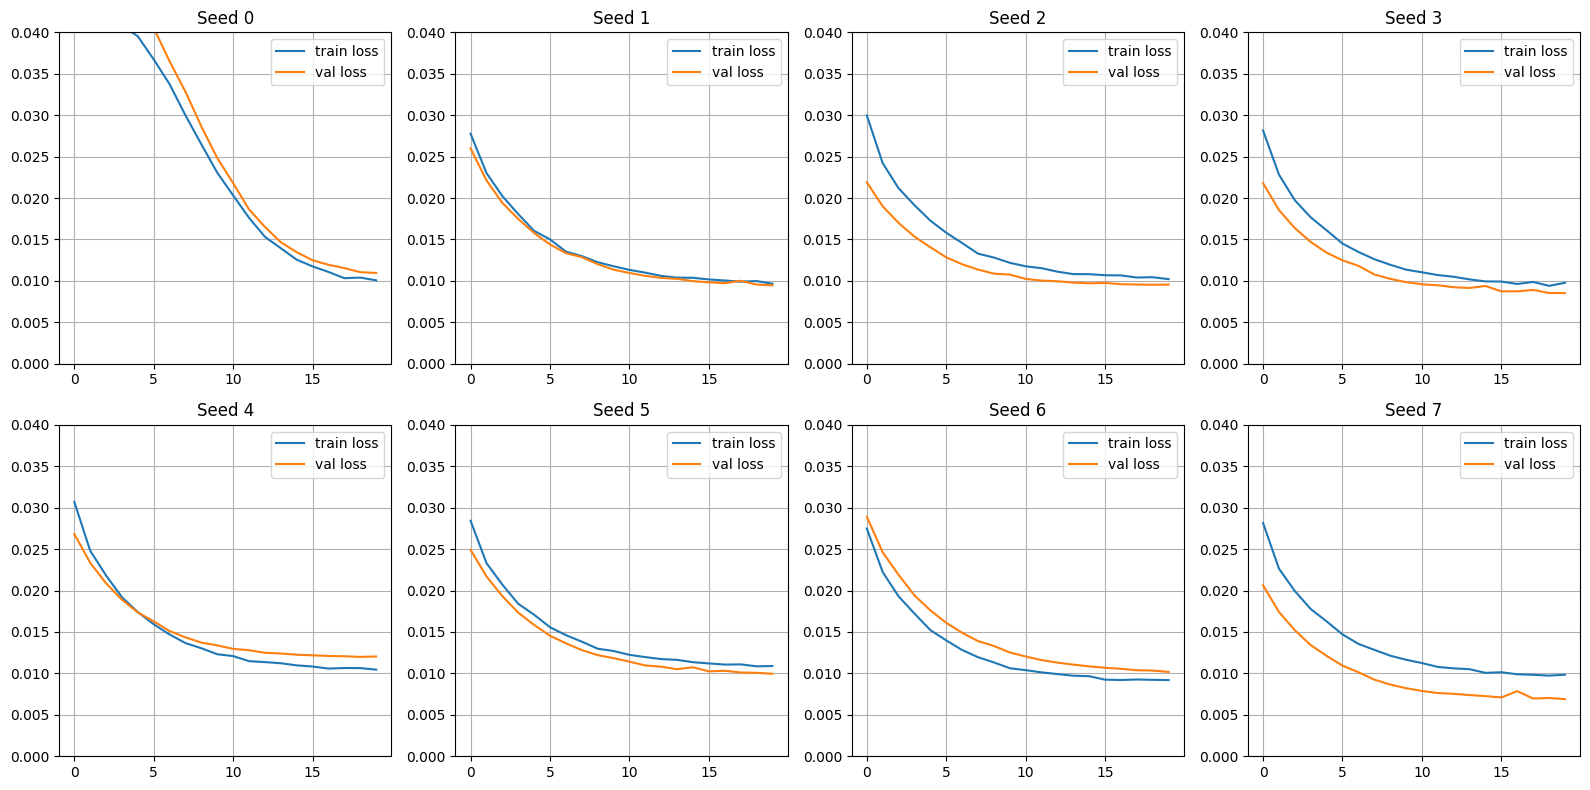

In [8]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for i in range(8):
    plot_data, SD_test, sys_test, test_loss = train_network('test', optimizer='SGD', sim_seed=np.random.seed(500), epochs=20)

    row = i // 4
    col = i % 4
    axs[row, col].plot(plot_data["train_loss"], label='train loss')
    axs[row, col].plot(plot_data["val_loss"], label='val loss')
    axs[row, col].legend()
    axs[row, col].grid()
    axs[row, col].set_title(f'Seed {i}')
    axs[row, col].set_ylim(0, 0.04)

fig.tight_layout()
plt.show()

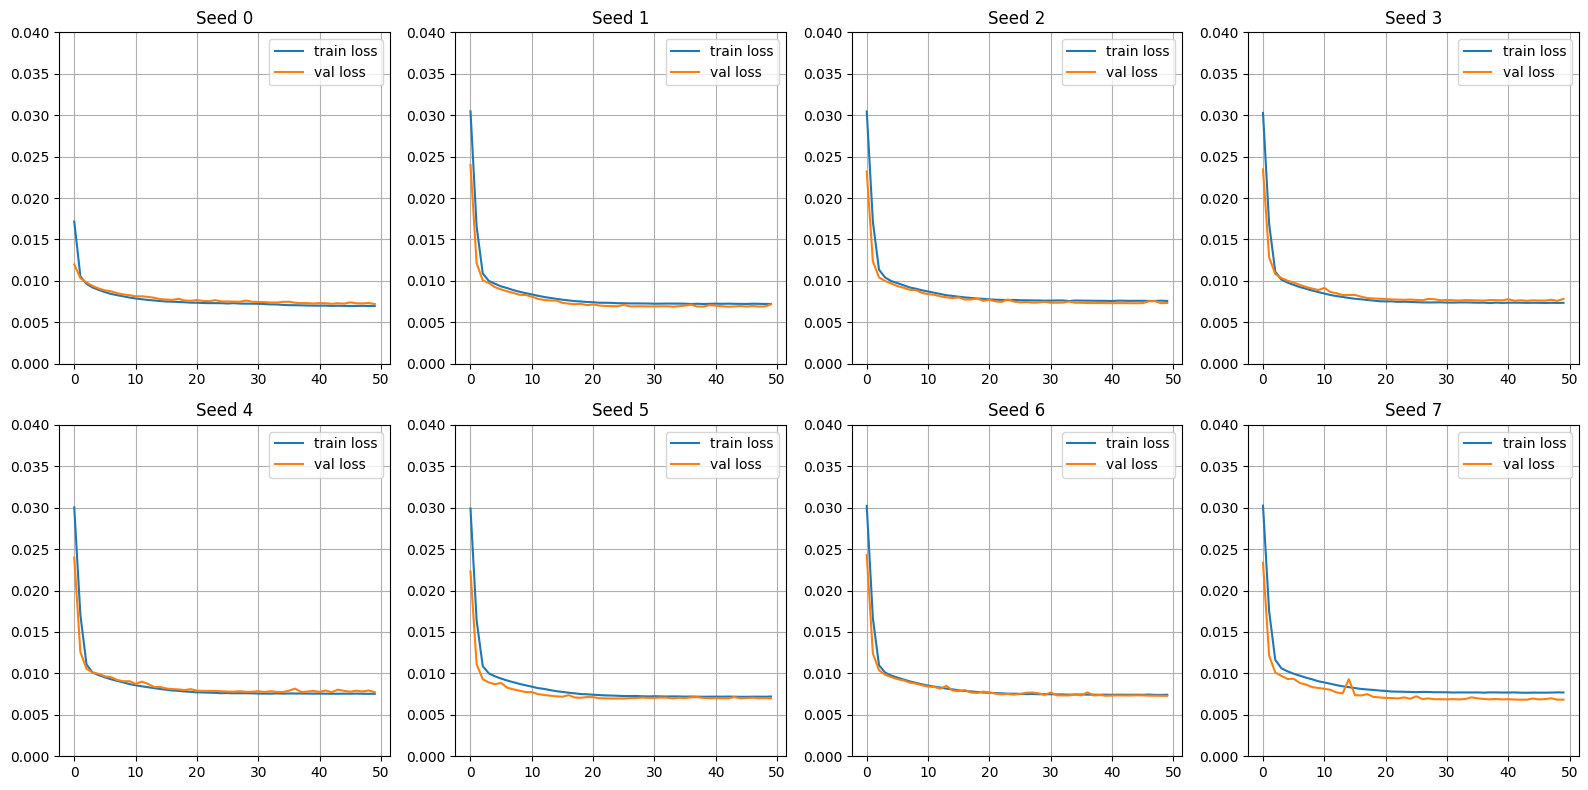

In [10]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for i in range(8):
    plot_data, SD_test, sys_test, test_loss = train_network('test', optimizer='SGD', sim_seed=np.random.seed(500), epochs=50, sims=10000)

    row = i // 4
    col = i % 4
    axs[row, col].plot(plot_data["train_loss"], label='train loss')
    axs[row, col].plot(plot_data["val_loss"], label='val loss')
    axs[row, col].legend()
    axs[row, col].grid()
    axs[row, col].set_title(f'Seed {i}')
    axs[row, col].set_ylim(0, 0.04)

fig.tight_layout()
plt.show()

# First week (on schedule means finish by Friday) [if updated: 7-2-2025]
For these exercises, you will want to produce new cells that generate the outputs. The notebook cells should run and produce the figures without input of the examiners.

## 1A-C: train the neural network
Adapt the script above for your exercises A-C such that it produces the desired results and plots. Describe the results/intepertation in this text baloon.

A. The current network implementation only looks at training data. This means that the network’s performance is over-estimated. Please use the validation set to monitor performance during training (note that we have already put the model on evaluation mode in line 59). At what point is the network fully trained? Explain how you know this. Show the effect from overfitting and underfitting.

The model is fully trained only at the very end of the epochs loop, so once the function has finished running. This is because the model changes the weights (optimiser.step()) for every iteration in the epochs loop (only in the training loop).

At first the model underfits, here the training loss is higher than the validation loss and the slope of the validation loss curve is negative. Overfitting does not occur in this example. The validation curve stays flat for after 175 epochs and does not start to rise again (yet). (This could change however if the model is retrained due to the some random parameters)

B. Similarly, use the test dataset to test for final performance. Explain why this is needed.

Once the model is fully trained we need to test the performance on a dataset that is new to the model. Otherwise the fact that the model was trained on the data would bias the performance. And if the validation set was used to determine the point where to stop training, this would also have an influence on the model, which is why a completely new dataset is chosen.

C. Currently, standard gradient descent optimizer is being used to train the network, with a learning rate of 0.01. Investigate the performance of the network for different optimizer (i.e. adam loss was discussed in the lecture) and explain what you see. What does the Adam optimizer do differently from the SGD optimizer that would make it perform better/differently?

The SGD optimizer uses just the gradient and a constant learning rate to find minima in the loss function.
The adam optimizer uses in addition to the gradient and a learning rate, both momentum (past gradients influence the step size (moving average)) and a decay of the moments (only a certain amount of past gradients to an extend defined by an exponential decay) to converge to a minimum faster than SGD.

The adam optimizer tends to find a minimum in the loss function much quicker than the SGD optimiser. 
The loss curve during training of the adam optimiser shows much higher variance than the one of the SGD optimiser. This is likely caused by the momentum in the adam optimiser, which means even when in a minimum, where the slope in the loss function vanishes, the step size is not 0. A step size unequal to 0 would mean that the optimizer takes a step out of the minimum. The fact that this carries on for many epochs likely means that the decay is not tuned properly.

Adagrad, a third optimizer that was tested performed the best. It reached the lowest loss and validation standard deviation and was on par with the SGD optimiser for systematic error. Its loss curve looks very similar to the one of the SGD optimizer but converges much faster.

The adagrad optimizer adjusts the learning rate based on the accumulation of squared gradients, this means it slows down over time, leading to a more stable loss curve compared to the adam optimizer.

### C) Different optimizers


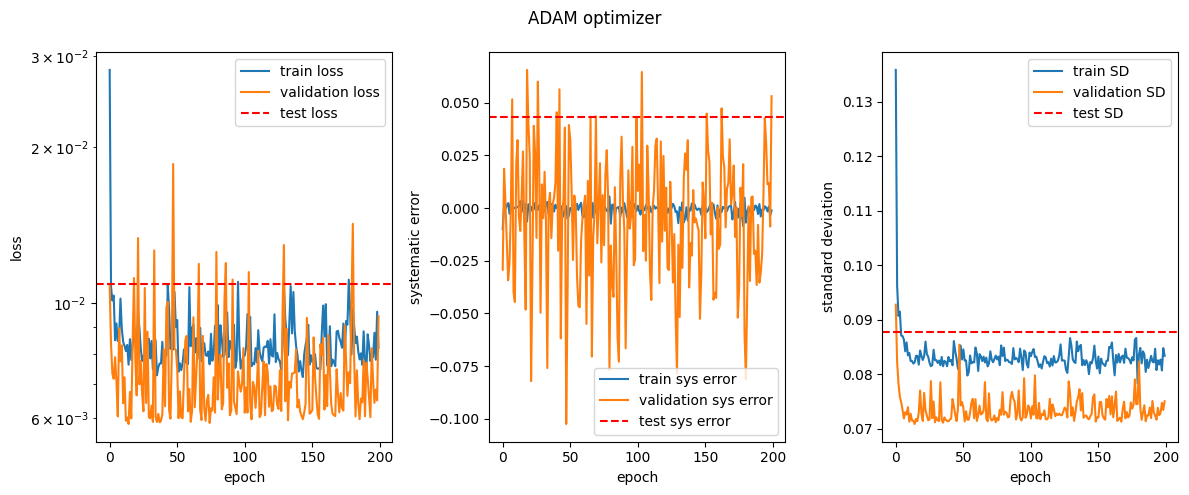

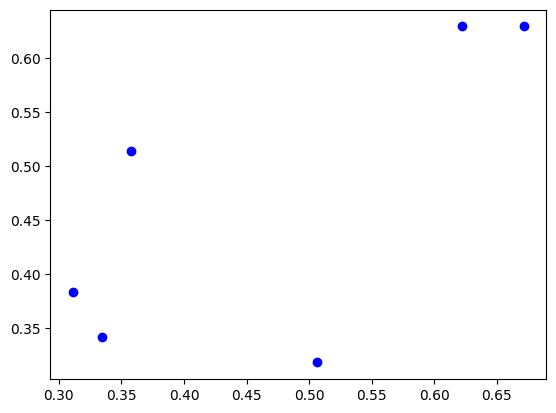

In [95]:
plot_data_ADAM, SD_test_ADAM, sys_test_ADAM, test_loss_ADAM = train_network('test_ADAM', optimizer='adam', sim_seed=69)

fig,axs = plt.subplots(1, 3, figsize=(12, 5))

fig.suptitle('ADAM optimizer')

axs[0].semilogy(plot_data_ADAM['train_loss'], label='train loss')
axs[0].semilogy(plot_data_ADAM['val_loss'], label='validation loss')
axs[0].axhline(y=test_loss_ADAM, color='r', linestyle='--', label='test loss')
axs[0].legend()
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')


axs[1].plot(plot_data_ADAM['sys_train'], label='train sys error')
axs[1].plot(plot_data_ADAM['sys_val'], label='validation sys error')
axs[1].axhline(y=sys_test_ADAM, color='r', linestyle='--', label='test sys error')
axs[1].legend()
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('systematic error')


axs[2].plot(plot_data_ADAM['SD_train'], label='train SD')
axs[2].plot(plot_data_ADAM['SD_val'], label='validation SD')
axs[2].axhline(y=SD_test_ADAM, color='r', linestyle='--', label='test SD')
axs[2].legend()
axs[2].set_xlabel('epoch')
axs[2].set_ylabel('standard deviation')

fig.tight_layout()
plt.show()

plt.scatter(np.array(plot_data_ADAM["table_val_f"][-1])[:,0], np.array(plot_data_ADAM["table_val_f"][-1])[:,1], color='b', label='total weighted')


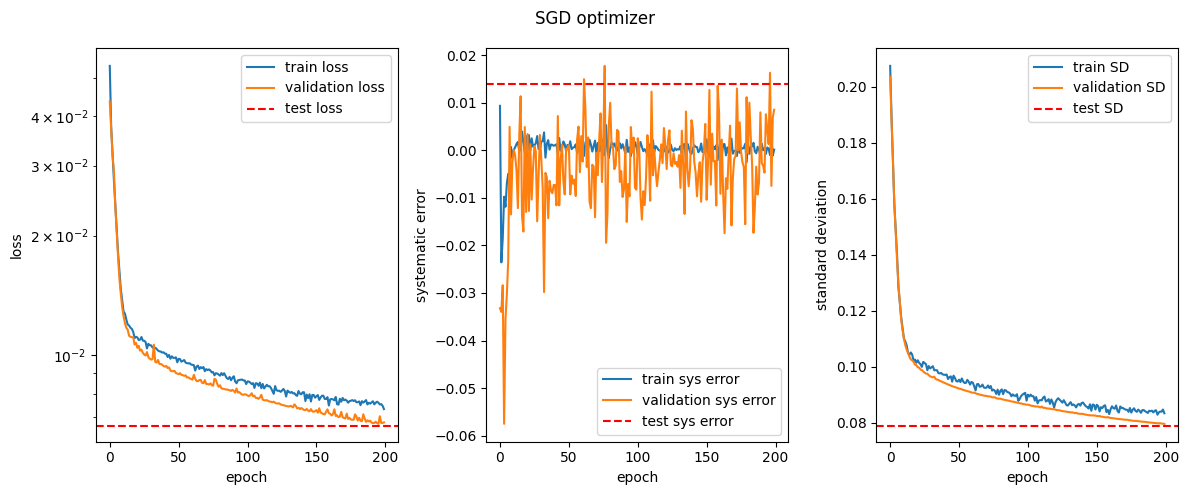

In [20]:
plot_data_SGD, SD_test_SGD, sys_test_SGD, test_loss_SGD = train_network('test_SGD', optimizer='SGD')

fig,axs = plt.subplots(1, 3, figsize=(12, 5))

fig.suptitle('SGD optimizer')

axs[0].semilogy(plot_data_SGD['train_loss'], label='train loss')
axs[0].semilogy(plot_data_SGD['val_loss'], label='validation loss')
axs[0].axhline(y=test_loss_SGD, color='r', linestyle='--', label='test loss')
axs[0].legend()
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')


axs[1].plot(plot_data_SGD['sys_train'])
axs[1].plot(plot_data_SGD['sys_val'])
axs[1].axhline(y=sys_test_SGD, color='r', linestyle='--')
axs[1].legend(['train sys error', 'validation sys error', 'test sys error'])
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('systematic error')


axs[2].plot(plot_data_SGD['SD_train'], label='train SD')
axs[2].plot(plot_data_SGD['SD_val'], label='validation SD')
axs[2].axhline(y=SD_test_SGD, color='r', linestyle='--', label='test SD')
axs[2].legend()
axs[2].set_xlabel('epoch')
axs[2].set_ylabel('standard deviation')

fig.tight_layout()
plt.show()

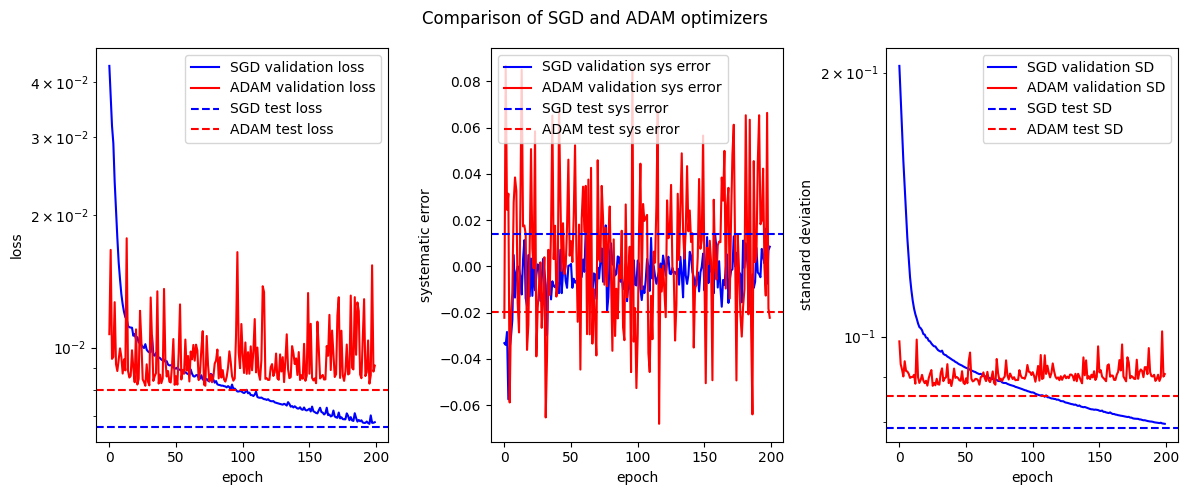

In [13]:
fig,axs = plt.subplots(1, 3, figsize=(12, 5))

fig.suptitle('Comparison of SGD and ADAM optimizers')

axs[0].semilogy(plot_data_SGD['val_loss'], color='b')
axs[0].semilogy(plot_data_ADAM['val_loss'], color='r')
axs[0].axhline(y=test_loss_SGD, color='b', linestyle='--')
axs[0].axhline(y=test_loss_ADAM, color='r', linestyle='--')
axs[0].legend(['SGD validation loss', 'ADAM validation loss', 'SGD test loss', 'ADAM test loss'])
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')


axs[1].plot(plot_data_SGD['sys_val'], color='b')
axs[1].plot(plot_data_ADAM['sys_val'], color='r')
axs[1].axhline(y=sys_test_SGD, color='b', linestyle='--')
axs[1].axhline(y=sys_test_ADAM, color='r', linestyle='--')
axs[1].legend(['SGD validation sys error', 'ADAM validation sys error', 'SGD test sys error','ADAM test sys error'])
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('systematic error')


axs[2].semilogy(plot_data_SGD['SD_val'], color='b')
axs[2].semilogy(plot_data_ADAM['SD_val'], color='r')
axs[2].axhline(y=SD_test_SGD, color='b', linestyle='--')
axs[2].axhline(y=SD_test_ADAM, color='r', linestyle='--')
axs[2].legend(['SGD validation SD', 'ADAM validation SD', 'SGD test SD', 'ADAM test SD'])
axs[2].set_xlabel('epoch')
axs[2].set_ylabel('standard deviation')

fig.tight_layout()
plt.show()

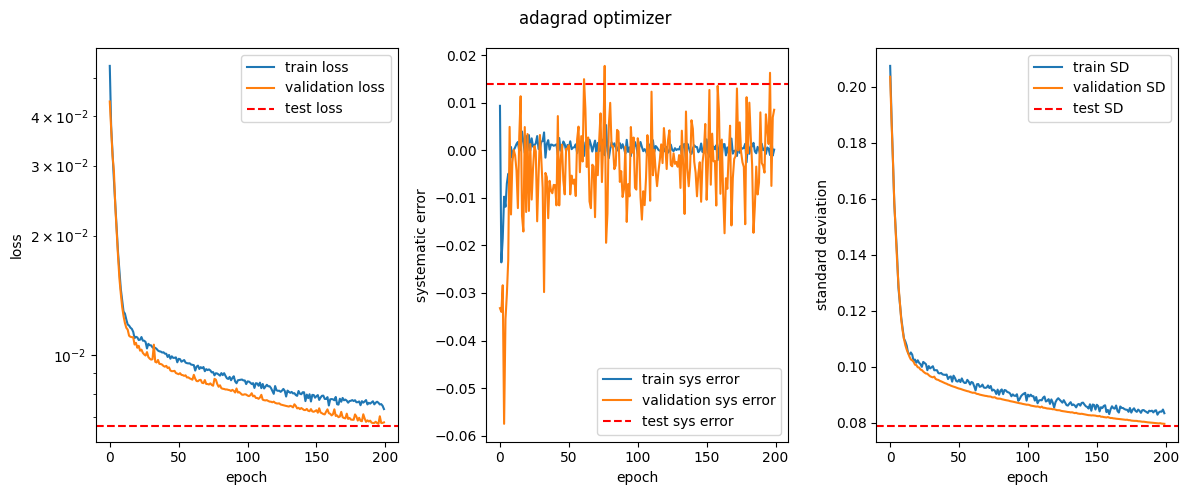

In [27]:
plot_data_ADAGRAD, SD_test_ADAGRAD, sys_test_ADAGRAD, test_loss_ADAGRAD = train_network('test_adagrad', optimizer='adagrad')

fig,axs = plt.subplots(1, 3, figsize=(12, 5))

fig.suptitle('adagrad optimizer')

axs[0].semilogy(plot_data_SGD['train_loss'], label='train loss')
axs[0].semilogy(plot_data_SGD['val_loss'], label='validation loss')
axs[0].axhline(y=test_loss_SGD, color='r', linestyle='--', label='test loss')
axs[0].legend()
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')


axs[1].plot(plot_data_SGD['sys_train'])
axs[1].plot(plot_data_SGD['sys_val'])
axs[1].axhline(y=sys_test_SGD, color='r', linestyle='--')
axs[1].legend(['train sys error', 'validation sys error', 'test sys error'])
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('systematic error')


axs[2].plot(plot_data_SGD['SD_train'], label='train SD')
axs[2].plot(plot_data_SGD['SD_val'], label='validation SD')
axs[2].axhline(y=SD_test_SGD, color='r', linestyle='--', label='test SD')
axs[2].legend()
axs[2].set_xlabel('epoch')
axs[2].set_ylabel('standard deviation')

fig.tight_layout()
plt.show()

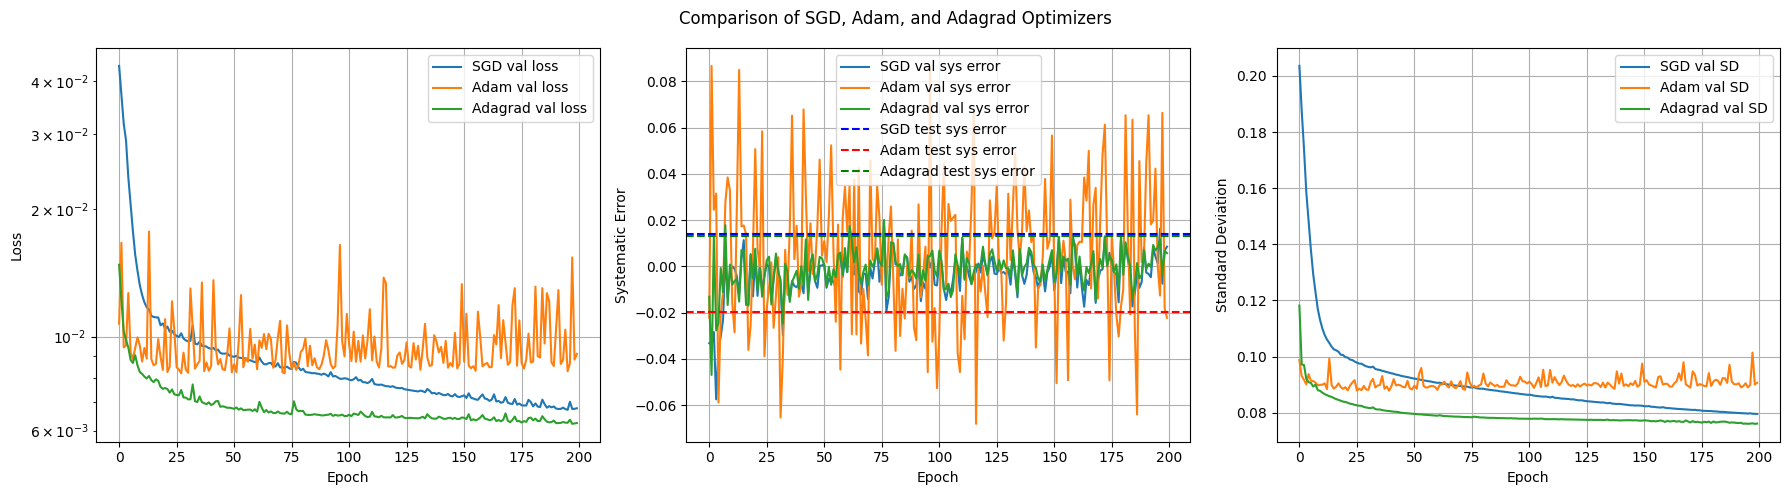

In [22]:
# Plot comparison of all three optimizers
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

fig.suptitle('Comparison of SGD, Adam, and Adagrad Optimizers')

# Plot for training and validation loss
# axs[0].semilogy(plot_data_SGD['train_loss'], label='SGD train loss')
axs[0].semilogy(plot_data_SGD['val_loss'], label='SGD val loss')
# axs[0].semilogy(plot_data_ADAM['train_loss'], label='Adam train loss')
axs[0].semilogy(plot_data_ADAM['val_loss'], label='Adam val loss')
# axs[0].semilogy(plot_data_ADAGRAD['train_loss'], label='Adagrad train loss')
axs[0].semilogy(plot_data_ADAGRAD['val_loss'], label='Adagrad val loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot for systematic error
axs[1].plot(plot_data_SGD['sys_val'], label='SGD val sys error')
axs[1].plot(plot_data_ADAM['sys_val'], label='Adam val sys error')
axs[1].plot(plot_data_ADAGRAD['sys_val'], label='Adagrad val sys error')
axs[1].axhline(y=sys_test_SGD, color='b', linestyle='--', label='SGD test sys error')
axs[1].axhline(y=sys_test_ADAM, color='r', linestyle='--', label='Adam test sys error')
axs[1].axhline(y=sys_test_ADAGRAD, color='g', linestyle='--', label='Adagrad test sys error')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Systematic Error')
axs[1].legend()
axs[1].grid(True)

# Plot for standard deviation
axs[2].plot(plot_data_SGD['SD_val'], label='SGD val SD')
axs[2].plot(plot_data_ADAM['SD_val'], label='Adam val SD')
axs[2].plot(plot_data_ADAGRAD['SD_val'], label='Adagrad val SD')
# axs[2].axhline(y=SD_test_SGD, color='b', linestyle='--', label='SGD test SD')
# axs[2].axhline(y=SD_test_ADAM, color='r', linestyle='--', label='Adam test SD')
# axs[2].axhline(y=SD_test_ADAGRAD, color='g', linestyle='--', label='Adagrad test SD')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Standard Deviation')
axs[2].legend()
axs[2].grid(True)

fig.tight_layout()
plt.show()

## D) Performance as function of learning rate

D.	Return back to SGD. Test how the performance depends on the learning rate. This can be done by plotting the systematic (sys_test) and random (SD_test) errors as function of learning rate (10<LR<0.0000001; steps in order of magnitude; e.g. 10, 1, 0.1, ….).
##### Plot the performance (sys_val and SD_val) as function of the learning rate and add this to your report. Explain what you see (hint: take a look at the loss curves).
easiest is to save the final performance and plot it in the jupyter notebook.

Observing the graphs, we identify an ideal learning rate at which the test loss reaches its lowest value. For smaller learning rates (e.g., 1e-7), both the validation and test errors are high but decrease significantly as the learning rate increases. This trend continues until a learning rate between 1e-4 and 1e-3, beyond which the error starts rising again.

The initially larger errors at small learning rates can be explained by the model's slow convergence, leading to a suboptimal solution, as seen in the error graph before 1e-4. Conversely, at excessively high learning rates, the algorithm likely overshoots the optimal solution, which is evident in the systematic error graph at 1e-3 and beyond. The optimal learning rate thus lies somewhere in between.

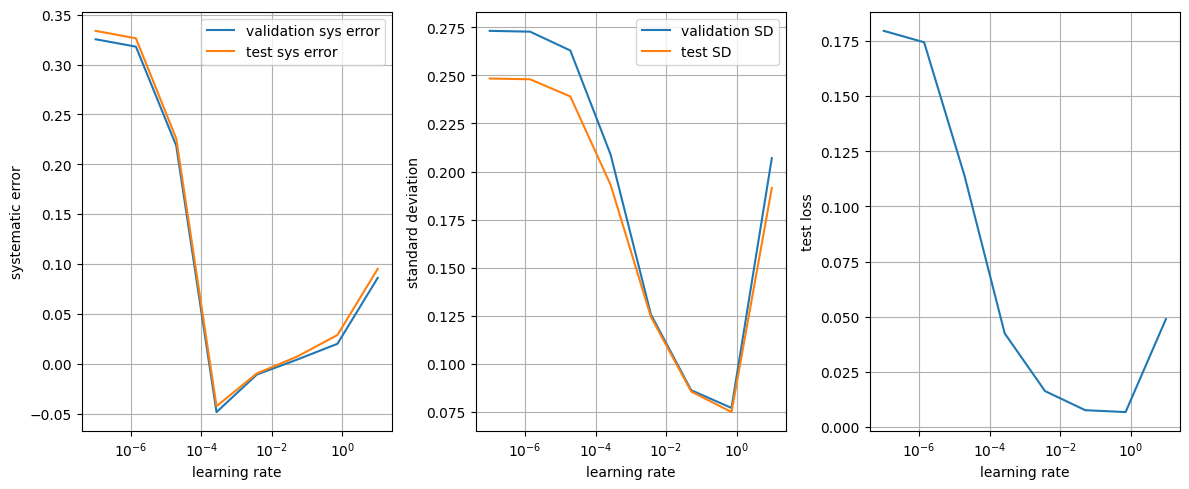

In [158]:
# train the network using the SGD optimizer for different learning rates

learning_rate = np.logspace(-7, 1, 8)

sys_val_list = []
sys_test_list = []
SD_val_list = []
SD_test_list = []
test_loss_list = []

for rates in learning_rate:
    plot_data, SD_test, sys_test, test_loss = train_network('test_SGD', optimizer='SGD', learningrate=rates)
    
    sys_val_list.append(plot_data['sys_val'][-1])
    sys_test_list.append(sys_test)
    SD_val_list.append(plot_data['SD_val'][-1])
    SD_test_list.append(SD_test)
    test_loss_list.append(test_loss)
    
fig,axs = plt.subplots(1, 3, figsize=(12, 5))

axs[0].plot(learning_rate, sys_val_list)
axs[0].plot(learning_rate, sys_test_list)
axs[0].legend(['validation sys error', 'test sys error'])
axs[0].set_xlabel('learning rate')
axs[0].set_ylabel('systematic error')
axs[0].set_xscale('log')
axs[0].grid(True)

axs[1].plot(learning_rate, SD_val_list)
axs[1].plot(learning_rate, SD_test_list)
axs[1].legend(['validation SD', 'test SD'])
axs[1].set_xlabel('learning rate')
axs[1].set_ylabel('standard deviation')
axs[1].set_xscale('log')
axs[1].grid(True)

axs[2].plot(learning_rate, test_loss_list)
axs[2].set_xlabel('learning rate')
axs[2].set_ylabel('test loss')
axs[2].set_xscale('log')
axs[2].grid(True)

fig.tight_layout()
plt.show()

## E) Performance as function of width and depth

E.	Plot the performance (sys_val and SD_val) as function of the width (number of neurons per layer: 5, 10, 20, 50, 100) and depth (number of hidden layers: 1, 2, ..., 8) of the network and add these to the report. Discuss how width and depth may influence the network; if it has this behaviour in your data, highlight it; if not, explain why it may not occur in your dataset.

Hint: currently, the width of the network copies the width of the data, so you need to uncouple the input width from the network width by adapting the "make model" code.
Tip: you only need to plot different widths for 1 depth (e.g. 2) and different depths for 1 width (e.g. 10).
Tip: possibly some effects get clearer when more training data is simulated ("sims" in data_sim). But also note that having too much training data may hide some of the effects from other exercises, so don't forget to revert it.

The first plots that are shown are the losses during training for the different network depths. These all have rouhgly the same trajectory, with some outliers, where the training loss seems to stay constant right away likely due to getting stuck in a local minimum.

The next set of plots shows the losses, systemic error and standard deviation for the testing dataset and the last epoch run of the validation dataset as a function of depth and width. For the depth plots the width was set to 5. For the width plots the depth was set to 2. 

For the depth, the magnitude of the systematic error increases with depth slightly, while the standard deviation stays constant apart from Some outlier peaks. This is likely caused by the same artifact that can be seen at the correseponding depths in the first set of plots. For all plots as a function of depth the validation and test curves are very similar. 

For the test dataset curve the width increases the magnitude of the systematic error at first and then decreases again. The validation curve has a similar trajectory but shifted to higher values. The standard deviation decreases for both datasets at first but then increases again slightly for the validation curve, while the test curve keeps falling slightly.

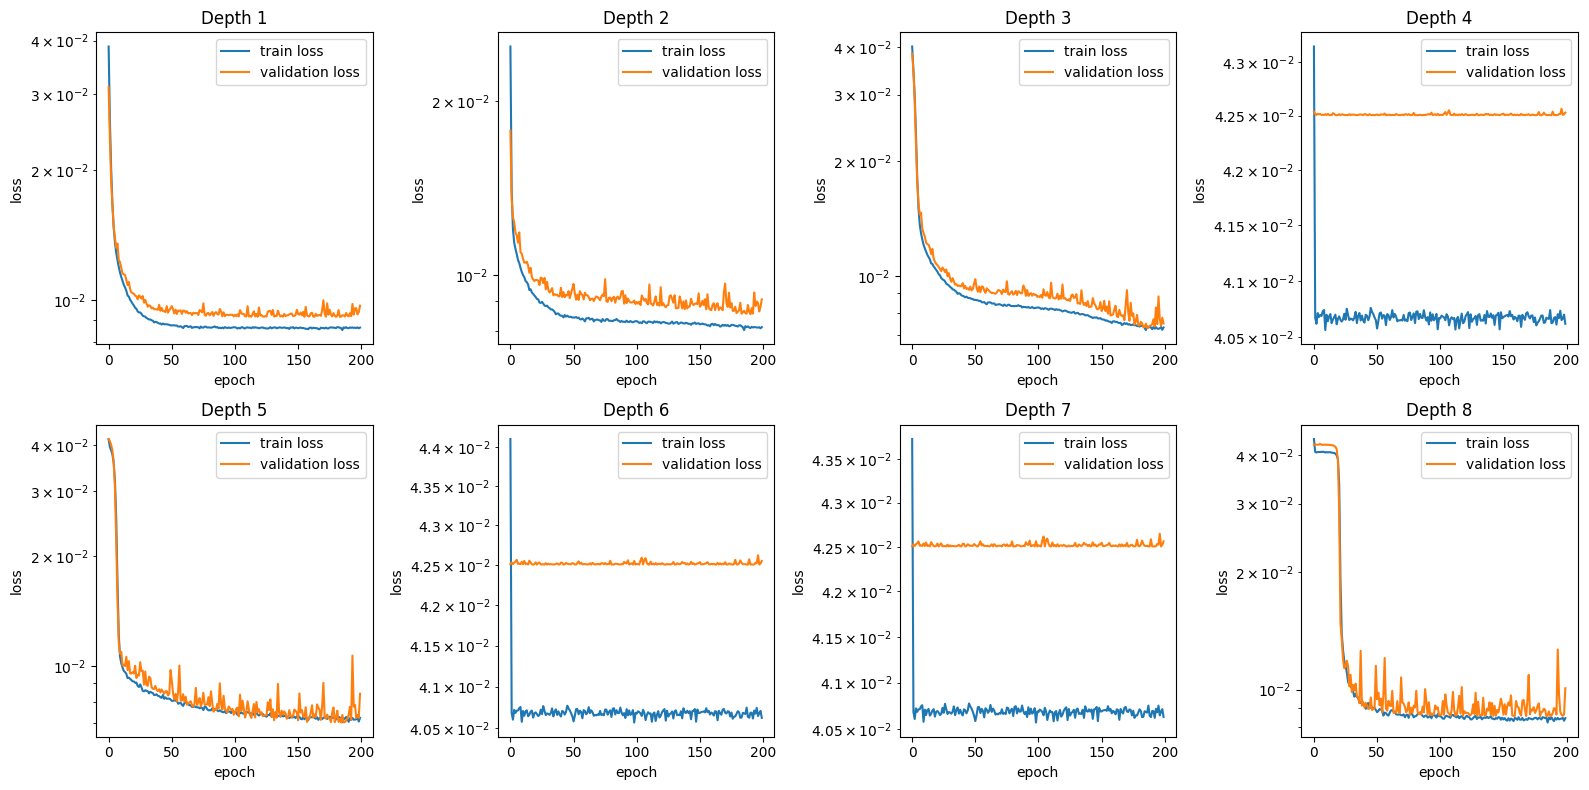

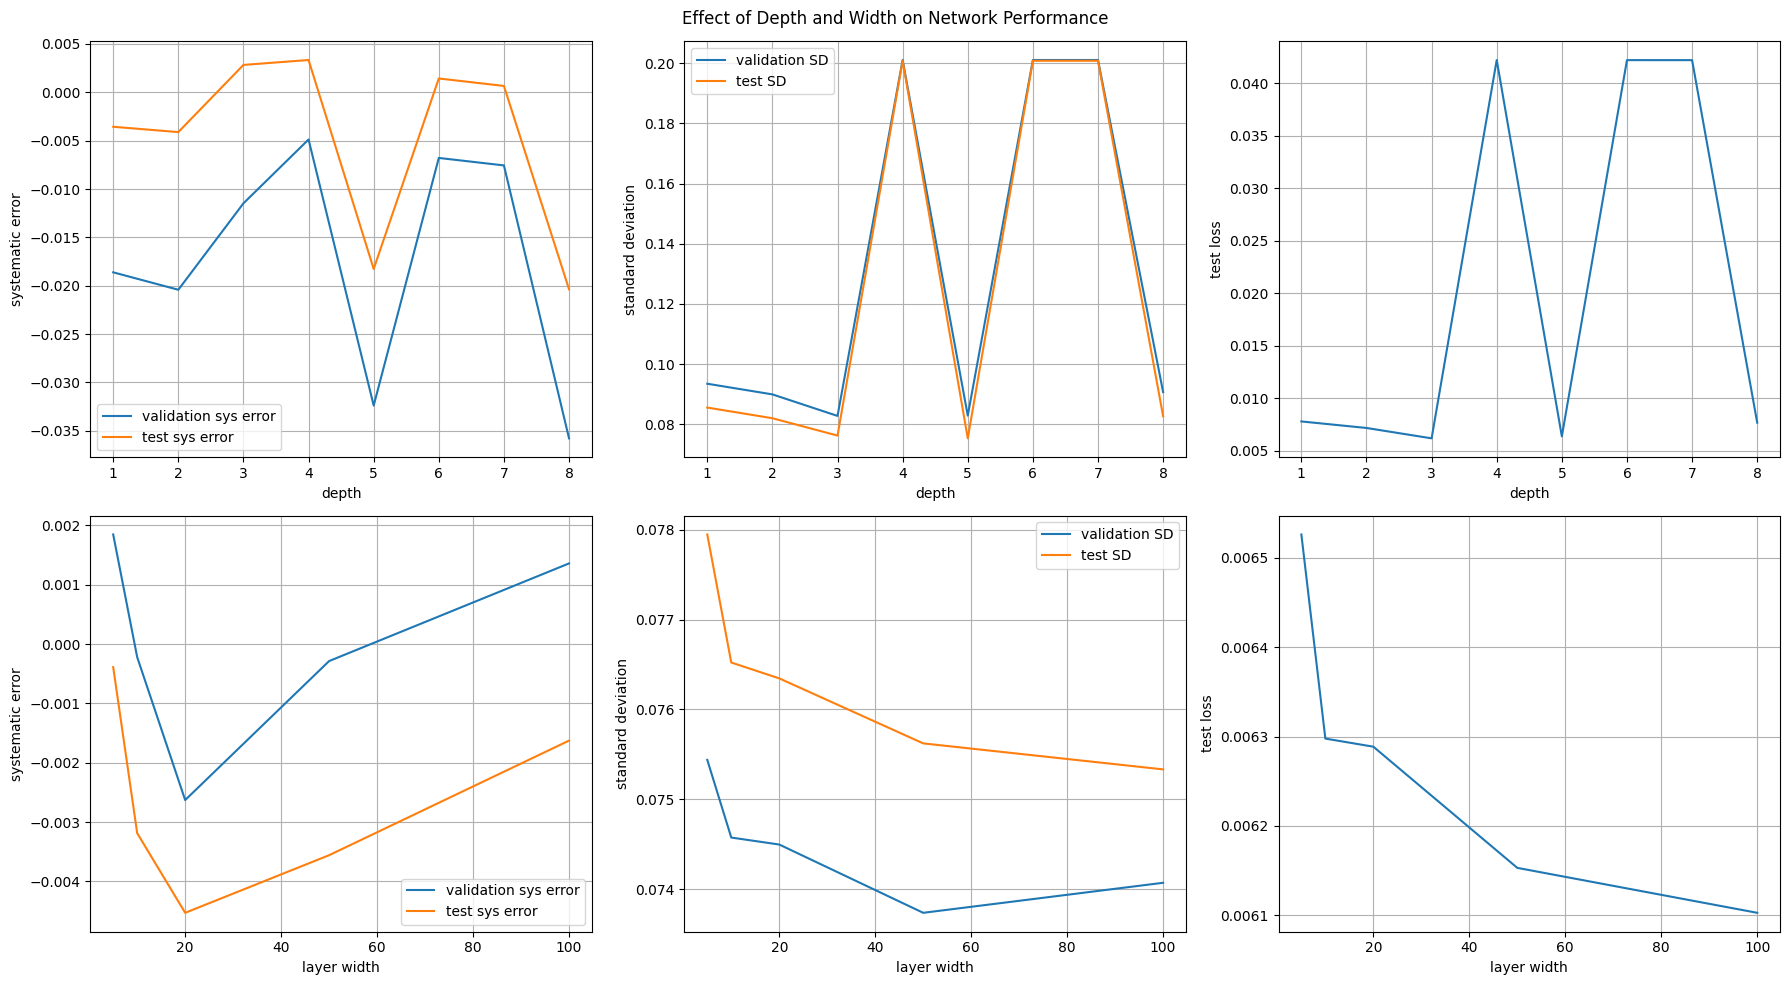

In [14]:
# train the network using the SGD optimizer for different depths and layer widths

depth = np.linspace(1, 8, 8, dtype=int)

layer_width = [5, 10, 20, 50, 100]

sys_val_list_depth = []
sys_test_list_depth = []
SD_val_list_depth = []
SD_test_list_depth = []
test_loss_list_depth = []

sys_val_list_width = []
sys_test_list_width = []
SD_val_list_width = []
SD_test_list_width = []
test_loss_list_width = []

fig_loss, axs_loss = plt.subplots(2, 4, figsize=(16, 8))

# leaving the width as 5 and changing the depth. Leaving width as 5 to be able to compare to the previous results
for i, layers in enumerate(depth):
    plot_data, SD_test, sys_test, test_loss = train_network('test_SGD', optimizer='SGD', hidden_layers=layers, sims = 5000, sim_seed=69)

    axs_loss[i // 4, i % 4].set_title(f'Depth {layers}')
    axs_loss[i // 4, i % 4].semilogy(plot_data['train_loss'], label='train loss')
    axs_loss[i // 4, i % 4].semilogy(plot_data['val_loss'], label='validation loss')
    axs_loss[i // 4, i % 4].legend()
    axs_loss[i // 4, i % 4].set_xlabel('epoch')
    axs_loss[i // 4, i % 4].set_ylabel('loss')
    
    sys_val_list_depth.append(plot_data['sys_val'][-1])
    sys_test_list_depth.append(sys_test)
    SD_val_list_depth.append(plot_data['SD_val'][-1])
    SD_test_list_depth.append(SD_test)
    test_loss_list_depth.append(test_loss)

fig_loss.tight_layout()
plt.show()
    
# leaving the depth as 2 and changing the width. Leaving depth as 2 to be able to compare to the previous results
for width in layer_width:
    plot_data, SD_test, sys_test, test_loss = train_network('test_SGD', optimizer='SGD', hidden_layers=2, hidden_width=width, sims= 10000, sim_seed=69)
    
    sys_val_list_width.append(plot_data['sys_val'][-1])
    sys_test_list_width.append(sys_test)
    SD_val_list_width.append(plot_data['SD_val'][-1])
    SD_test_list_width.append(SD_test)
    test_loss_list_width.append(test_loss)

fig, axs = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('Effect of Depth and Width on Network Performance')

# Plot for depth
axs[0, 0].plot(depth, sys_val_list_depth)
axs[0, 0].plot(depth, sys_test_list_depth)
axs[0, 0].legend(['validation sys error', 'test sys error'])
axs[0, 0].set_xlabel('depth')
axs[0, 0].set_ylabel('systematic error')
axs[0, 0].grid(True)

axs[0, 1].plot(depth, SD_val_list_depth)
axs[0, 1].plot(depth, SD_test_list_depth)
axs[0, 1].legend(['validation SD', 'test SD'])
axs[0, 1].set_xlabel('depth')
axs[0, 1].set_ylabel('standard deviation')
axs[0, 1].grid(True)

axs[0, 2].plot(depth, test_loss_list_depth)
axs[0, 2].set_xlabel('depth')
axs[0, 2].set_ylabel('test loss')
axs[0, 2].grid(True)

# Plot for width
axs[1, 0].plot(layer_width, sys_val_list_width)
axs[1, 0].plot(layer_width, sys_test_list_width)
axs[1, 0].legend(['validation sys error', 'test sys error'])
axs[1, 0].set_xlabel('layer width')
axs[1, 0].set_ylabel('systematic error')
axs[1, 0].grid(True)

axs[1, 1].plot(layer_width, SD_val_list_width)
axs[1, 1].plot(layer_width, SD_test_list_width)
axs[1, 1].legend(['validation SD', 'test SD'])
axs[1, 1].set_xlabel('layer width')
axs[1, 1].set_ylabel('standard deviation')
axs[1, 1].grid(True)

axs[1, 2].plot(layer_width, test_loss_list_width)
axs[1, 2].set_xlabel('layer width')
axs[1, 2].set_ylabel('test loss')
axs[1, 2].grid(True)

fig.tight_layout()
plt.show()

The first plots that are shown are the losses during training for the different network depths. These all have rouhgly the same trajectory, with some outliers, where the training loss seems to stay constant right away likely due to getting stuck in a local minimum.

The next set of plots shows the losses, systemic error and standard deviation for the testing dataset and the last epoch run of the validation dataset as a function of depth and width. For the depth plots the width was set to 5. For the width plots the depth was set to 2. 

For the depth, the magnitude of the systematic error increases with depth slightly if the outliers are ignored, while the standard deviation stays constant apart from the outlier peaks. The outliers are likely caused by the same artifact that can be seen at the correseponding depths in the first set of plots. For all plots as a function of depth the validation and test curves are very similar. 

For the test dataset curve, the width increases the magnitude of the systematic error at first and then decreases again after a width of 20. The validation curve has a similar trajectory but is shifted to higher values. The standard deviation decreases for both datasets at first but then increases again slightly for the validation curve, while the test curve keeps falling slightly.

The test loss stays roughly constant apart from the outliers for the depth plot while it drops slightly for the width plot.



The number of hidden layers (depth) does not seem to have a large impact on the performance of the neural network. The width of the hidden layers improved performance very slighly, reducing the systematic error slightly above a width of 20 layers. This could mean that higher widths are better able to reproduce the ground truth, although the changes were not large nor consitent enough to confirm this.

In conclusion, the changes in performance due to changing the network size were marginal and not consistent, further testing is necessary to find a more meaningful conclusion.
 

## F) Batch sizes

F.	Try different batch sizes (1, 4, 16, 64, 128, 516).Explain the behavior of the network you see.What is the effect of having smaller batches? And larger batches?

To examine the effect of different batch sizes, we plotted a graph with the validation loss over 200 epochs and a second graph with the test loss over discrete batch sizes on a log scale. From the first graph, we see that smaller batch sizes seem to result in a lower validation loss. The other notable difference is the variance of the validation loss curve, which appears to decrease as the batch size increases, showing a more stable trajectory. This behavior can be explained by smaller batch sizes introducing more noise in the gradient updates, which helps escape local minima and leads to improved generalization. Larger batch sizes result in more stable updates, smoothing the validation curve at the potential cost of reduced generalization.

The second graph shows that the trend already present in the validation loss from the first graph is similar for the test loss, as the test loss increases for larger batch sizes. This is likely due to the reduced noise in the gradient updates, which, while stabilizing the learning process, may cause the model to converge to sharper minima. Thus, smaller batch sizes despite their noisier updates can lead to better generalization, as they help the model to explore a larger range of solutions by preventing the model from getting stuck at a suboptimal local minima.

/var/folders/zd/05ndgbcd4k35_hn1kps4c8sr0000gn/T/ipykernel_80748/1515863943.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('jet', len(batchsizes))


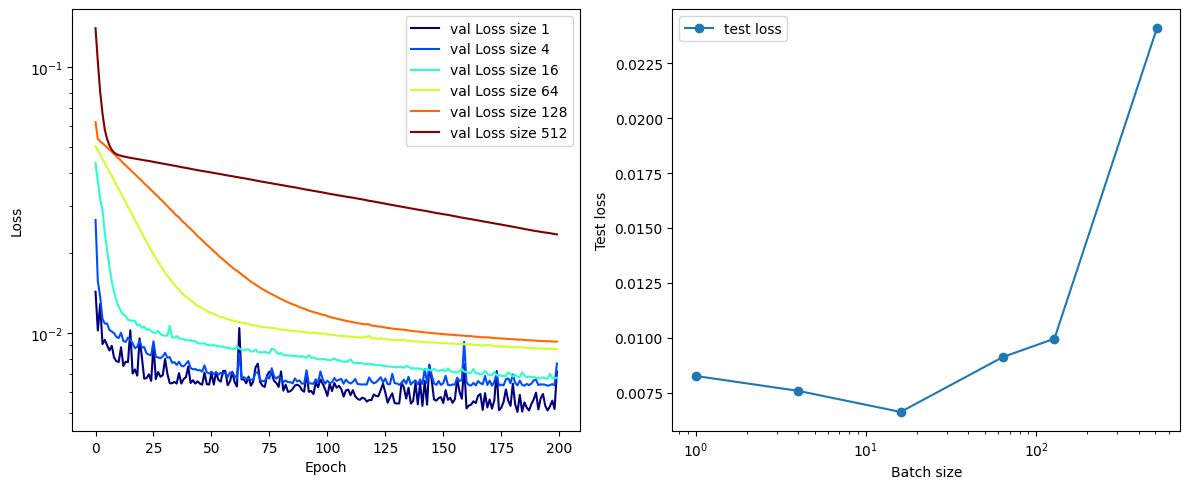

In [15]:
batchsizes = [1, 4, 16, 64, 128, 512]  # Corrected 516 to 512
cmap = plt.cm.get_cmap('jet', len(batchsizes))

test_loss_list = []

fig, axs = plt.subplots(1, 2, figsize=(12, 5)) 

for i, size in enumerate(batchsizes):
    plot_data, SD_test, sys_test, test_loss = train_network('test_SGD', optimizer='SGD', batch_size=size)

    axs[0].semilogy(plot_data['val_loss'], color=cmap(i), label=f'val Loss size {size}')
    test_loss_list.append(test_loss)

# Second plot for test loss
axs[1].semilogx(batchsizes, test_loss_list, marker='o', label='test loss')

axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[1].set_xlabel('Batch size')
axs[1].set_ylabel('Test loss')
axs[1].legend()

plt.tight_layout()
plt.show()  

## G) Overtraining

G.Chose 3 hidden layers, width of 40,  learning rate of 0.1 and batch size of 2. Now train the network for 3000 epochs. At what point in the network fully trained? How do you see this? Does any overfitting occur?

To explore when our model is fully trained, we plot both the train and validation loss over 3000 epochs. The model is fully trained at the point where the validation loss plateaus and no longer decreases significantly. By plotting both loss functions as smoothed curves, we can clearly see that this point occurs somewhere between epochs 400 and 500. Shortly after (epoch > 600), the validation loss starts increasing while the training loss continues to decrease, indicating overfitting. This suggests that the model is memorizing training data rather than generalizing well to new data. 

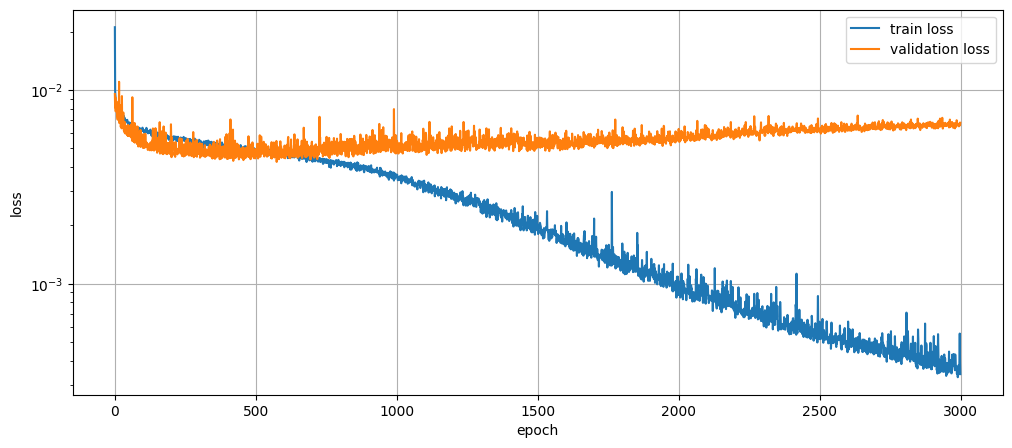

In [16]:
#G.Chose 3 hidden layers, width of 40,  learning rate of 0.1 and batch size of 2. Now train the network for 3000 epochs. At what point in the network fully trained? How do you see this? Does any overfitting occur?

plot_data_G, SD_test_G, sys_test_G, test_loss_G = train_network('test_SGD', optimizer='SGD', epochs=3000, hidden_layers=3, hidden_width=40, learningrate=0.1, batch_size=2)

plt.figure(figsize=(12, 5))

plt.semilogy(plot_data_G['train_loss'], label='train loss')
plt.semilogy(plot_data_G['val_loss'], label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()

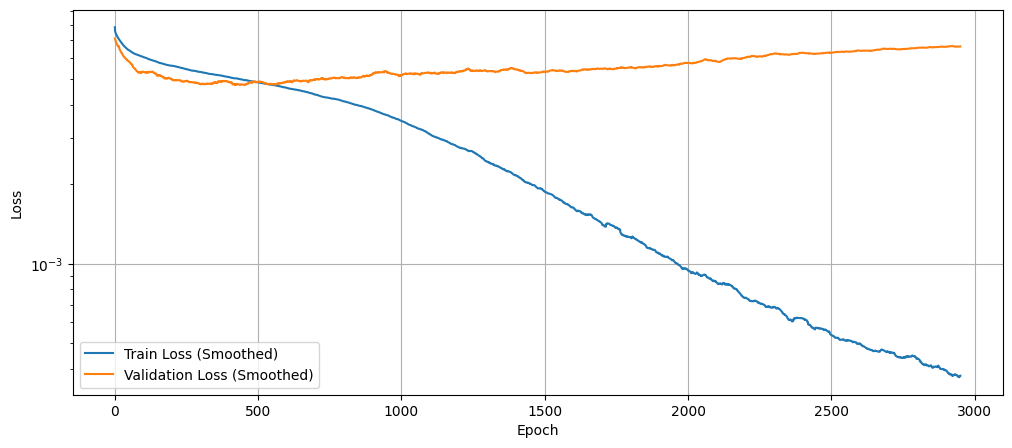

In [17]:
# Function for Simple Moving Average (SMA)
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply moving average with a window size of 50 
window_size = 50
smoothed_train_loss = moving_average(plot_data_G['train_loss'], window_size)
smoothed_val_loss = moving_average(plot_data_G['val_loss'], window_size)

plt.figure(figsize=(12, 5))
plt.semilogy(smoothed_train_loss, label='Train Loss (Smoothed)')
plt.semilogy(smoothed_val_loss, label='Validation Loss (Smoothed)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Second week (on schedule means finish by Wednesday) [if updated: 12-2-2025]
H.	Currently, the model uses a Relu activation function. Test the effect of different activation funtions on the network performance. Show how well does a sigmoid or ELU work (i.e. what is the effect on performance)?

Note, you can either:
- adapt the scripts above to program this "neatly" as input parameter.
- redefine new "programs" below that have the new properties you want.

Note that in the case of option 1, your programs need to stay backwards compatible, as examiners will need to be able to rerun your code and reproduce your results!

## H) Activation functions

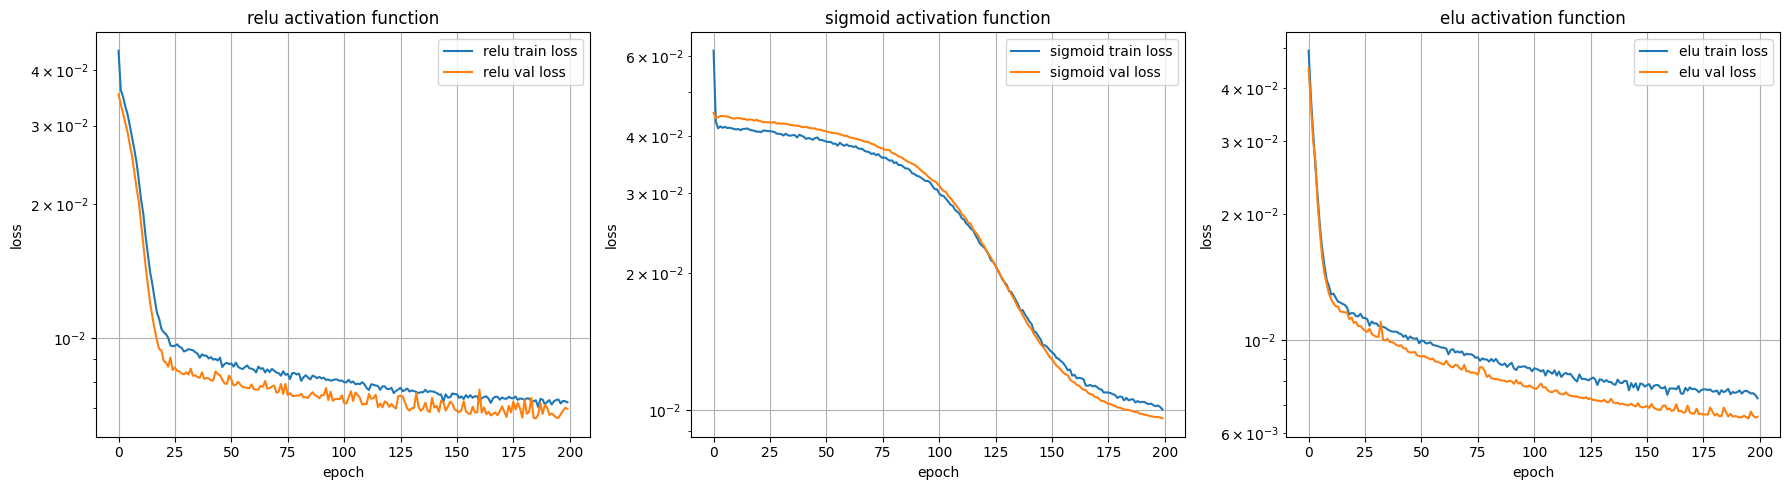

In [17]:
# Test for different activation functions

act_functions = ['relu', 'sigmoid', 'elu']

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, function in enumerate(act_functions):
    plot_data_G, SD_test_G, sys_test_G, test_loss_G = train_network('test_SGD', optimizer='SGD', activation_function=function)

    axs[i].semilogy(plot_data_G['train_loss'], label=f'{function} train loss')
    axs[i].semilogy(plot_data_G['val_loss'], label=f'{function} val loss')
    axs[i].set_xlabel('epoch')
    axs[i].set_ylabel('loss')
    axs[i].legend()
    axs[i].grid(True)
    axs[i].set_title(f'{function} activation function')

plt.legend
plt.tight_layout()

plt.show()

## I) More network outputs (D, Dp)

So far, we simualted a small amount of data, as it is easier to show overfitting etc. Note that you may want to simulate somewhat more data for this and the following exercises. This can be achieved by setting sims=100000 for the following exercises

I.	Let the network also predict D and Dp (note x[1] and x[3] are D and Dp respectively). Show the loss curve of D and Dp and explain how you can see that they have been implemented properly/the model is learning them.

o	The network will need more than 1 output --> tip, use loss_D.backward(retain_graph=True) for the first two losses to remember losses and propogate all 3 losses backward in turn

o	Alternatively, you could train 3 networks simultaniously

Note that 0<f<1 on avergae is orders of magnitude larger than D and Dp. To ensure all three losses equally affect the network weights you may want to enlarge the loss of D and Dp by multiplying them with some value.


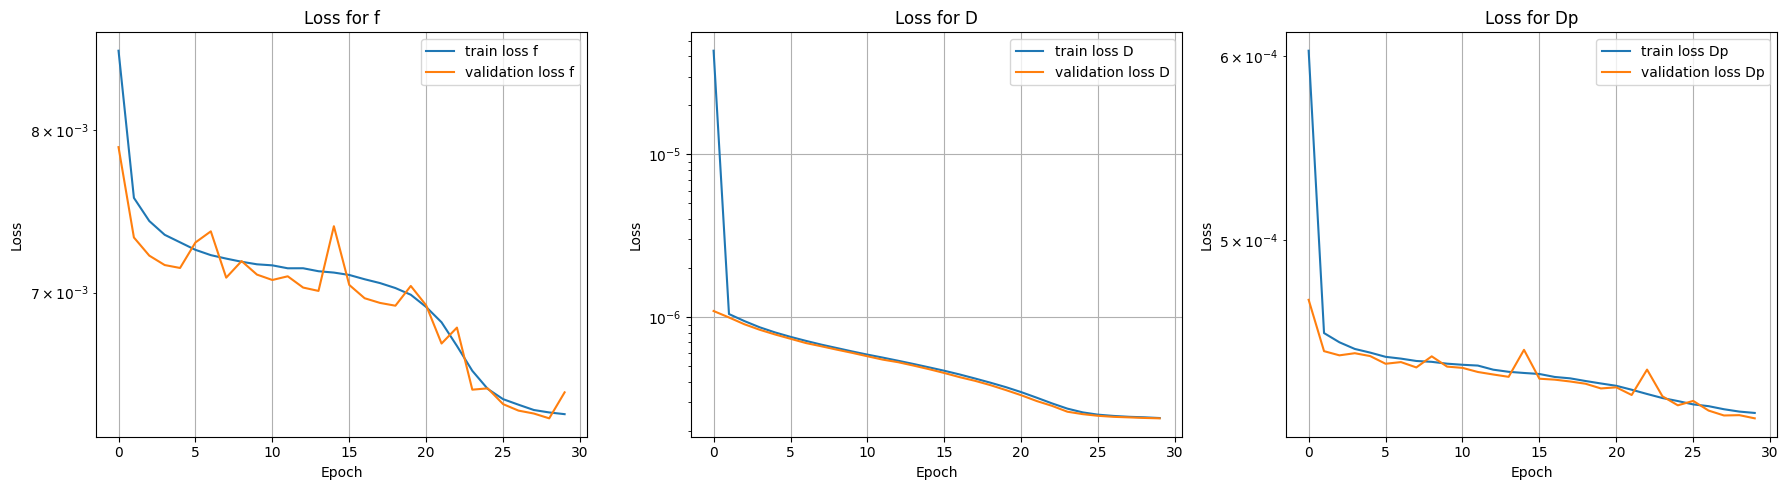

In [26]:
plot_data_D_Dp, SD_test_D_Dp, sys_test_D_Dp, test_loss_D_Dp = train_network('I', optimizer='adagrad', activation_function='elu', do_D_Dp=True, output_scaling=False, sims=100000, epochs=30, hidden_width=30, hidden_layers=2, wandb_interval=1)



fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot for f
axs[0].semilogy(plot_data_D_Dp["train_loss"], label='train loss f')
axs[0].semilogy(plot_data_D_Dp["val_loss"], label='validation loss f')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)
axs[0].set_title('Loss for f')

# Plot for D
axs[1].semilogy(plot_data_D_Dp["train_loss_D"], label='train loss D')
axs[1].semilogy(plot_data_D_Dp["val_loss_D"], label='validation loss D')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)
axs[1].set_title('Loss for D')

# Plot for Dp
axs[2].semilogy(plot_data_D_Dp["train_loss_Dp"], label='train loss Dp')
axs[2].semilogy(plot_data_D_Dp["val_loss_Dp"], label='validation loss Dp')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid(True)
axs[2].set_title('Loss for Dp')

plt.tight_layout()
plt.show()

## J) Output scaling

J.	Use the sigmoid in the final layer to constrain 0.5e-3 <D< 3.5e-3; 0<f<1; 5e-3<D*<130e-3. Explain how you did this.
Note: D, f and D* are in very different parameter value ranges, and hence their RMS is too. A network will focus on the largest loss. You may want to scale the RMS to similar ranges for the network to consider all 3 parameters during optmizing.
Also note: You may want to play with hyperparameters.

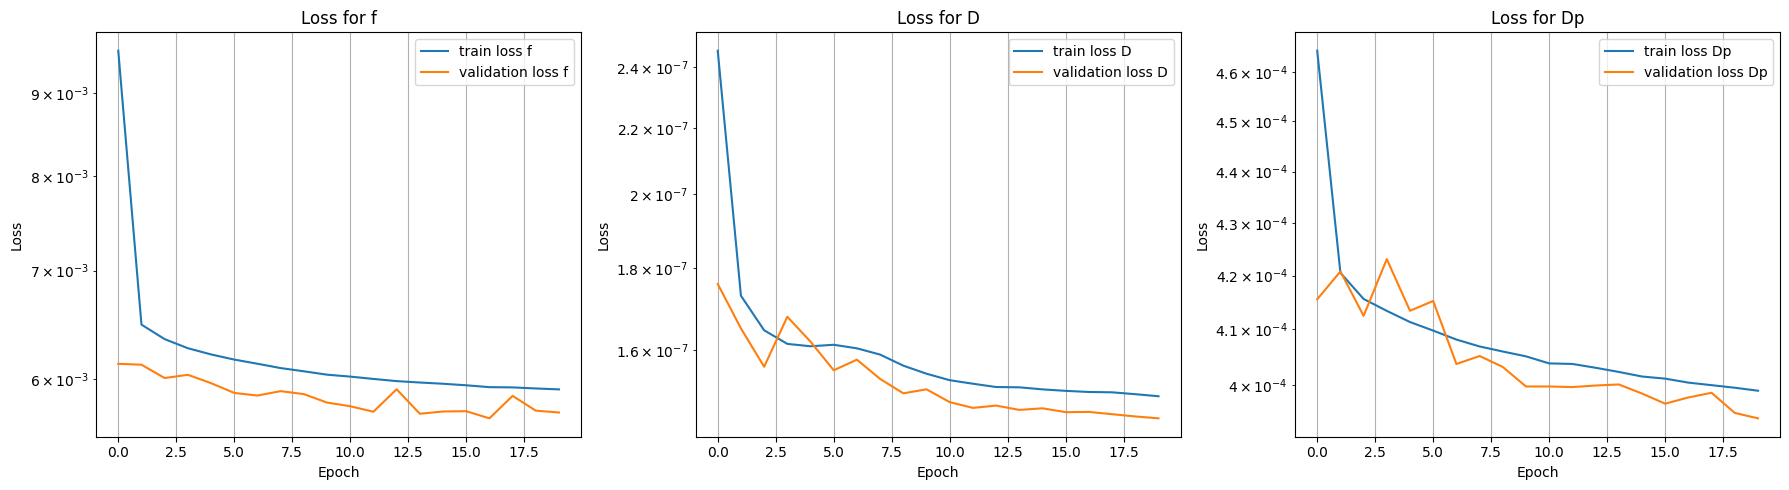

In [50]:
plot_data_D_Dp, SD_test_D_Dp, sys_test_D_Dp, test_loss_D_Dp = train_network('J', optimizer='adagrad', activation_function='relu', do_D_Dp=True, output_scaling=True, sims=100000, epochs=15, hidden_width=30, hidden_layers=2)


fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot for f
axs[0].semilogy(plot_data_D_Dp["train_loss"], label='train loss f')
axs[0].semilogy(plot_data_D_Dp["val_loss"], label='validation loss f')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)
axs[0].set_title('Loss for f')

# Plot for D
axs[1].semilogy(plot_data_D_Dp["train_loss_D"], label='train loss D')
axs[1].semilogy(plot_data_D_Dp["val_loss_D"], label='validation loss D')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)
axs[1].set_title('Loss for D')

# Plot for Dp
axs[2].semilogy(plot_data_D_Dp["train_loss_Dp"], label='train loss Dp')
axs[2].semilogy(plot_data_D_Dp["val_loss_Dp"], label='validation loss Dp')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid(True)
axs[2].set_title('Loss for Dp')

plt.tight_layout()
plt.show()

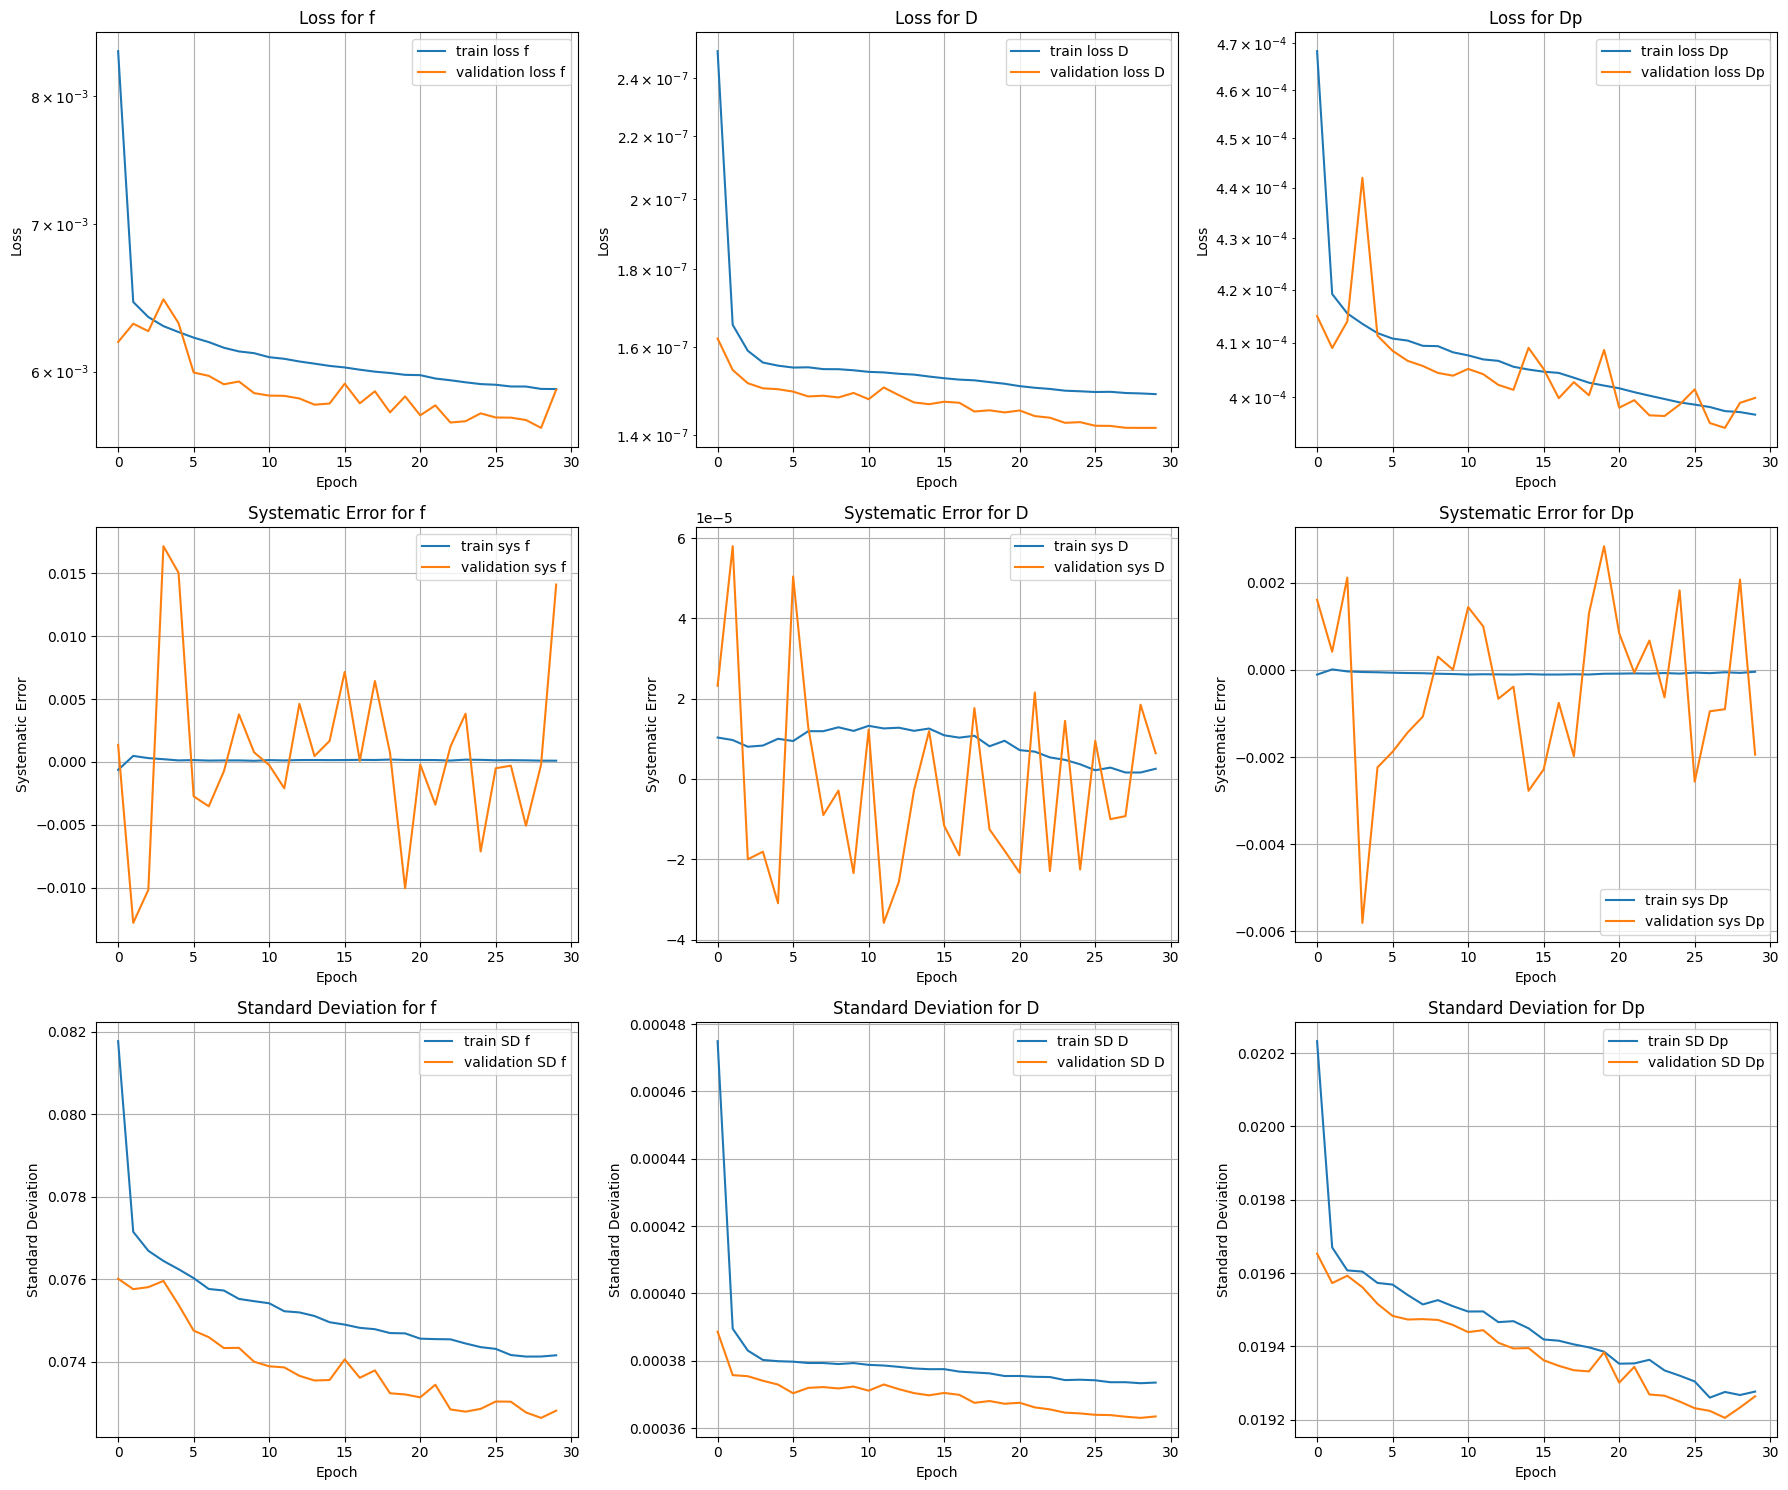

In [28]:
plot_data_D_Dp, SD_test_D_Dp, sys_test_D_Dp, test_loss_D_Dp = train_network('J', optimizer='adagrad', activation_function='elu', do_D_Dp=True, output_scaling=True, sims=100000, epochs=30, hidden_width=30, hidden_layers=2, wandb_interval=1)
fig, axs = plt.subplots(3, 3, figsize=(18, 15))

# Plot for f
axs[0, 0].semilogy(plot_data_D_Dp["train_loss"], label='train loss f')
axs[0, 0].semilogy(plot_data_D_Dp["val_loss"], label='validation loss f')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()
axs[0, 0].grid(True)
axs[0, 0].set_title('Loss for f')

axs[1, 0].plot(plot_data_D_Dp["sys_train"], label='train sys f')
axs[1, 0].plot(plot_data_D_Dp["sys_val"], label='validation sys f')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Systematic Error')
axs[1, 0].legend()
axs[1, 0].grid(True)
axs[1, 0].set_title('Systematic Error for f')

axs[2, 0].plot(plot_data_D_Dp["SD_train"], label='train SD f')
axs[2, 0].plot(plot_data_D_Dp["SD_val"], label='validation SD f')
axs[2, 0].set_xlabel('Epoch')
axs[2, 0].set_ylabel('Standard Deviation')
axs[2, 0].legend()
axs[2, 0].grid(True)
axs[2, 0].set_title('Standard Deviation for f')

# Plot for D
axs[0, 1].semilogy(plot_data_D_Dp["train_loss_D"], label='train loss D')
axs[0, 1].semilogy(plot_data_D_Dp["val_loss_D"], label='validation loss D')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()
axs[0, 1].grid(True)
axs[0, 1].set_title('Loss for D')

axs[1, 1].plot(plot_data_D_Dp["sys_train_D"], label='train sys D')
axs[1, 1].plot(plot_data_D_Dp["sys_val_D"], label='validation sys D')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Systematic Error')
axs[1, 1].legend()
axs[1, 1].grid(True)
axs[1, 1].set_title('Systematic Error for D')

axs[2, 1].plot(plot_data_D_Dp["SD_train_D"], label='train SD D')
axs[2, 1].plot(plot_data_D_Dp["SD_val_D"], label='validation SD D')
axs[2, 1].set_xlabel('Epoch')
axs[2, 1].set_ylabel('Standard Deviation')
axs[2, 1].legend()
axs[2, 1].grid(True)
axs[2, 1].set_title('Standard Deviation for D')

# Plot for Dp
axs[0, 2].semilogy(plot_data_D_Dp["train_loss_Dp"], label='train loss Dp')
axs[0, 2].semilogy(plot_data_D_Dp["val_loss_Dp"], label='validation loss Dp')
axs[0, 2].set_xlabel('Epoch')
axs[0, 2].set_ylabel('Loss')
axs[0, 2].legend()
axs[0, 2].grid(True)
axs[0, 2].set_title('Loss for Dp')

axs[1, 2].plot(plot_data_D_Dp["sys_train_Dp"], label='train sys Dp')
axs[1, 2].plot(plot_data_D_Dp["sys_val_Dp"], label='validation sys Dp')
axs[1, 2].set_xlabel('Epoch')
axs[1, 2].set_ylabel('Systematic Error')
axs[1, 2].legend()
axs[1, 2].grid(True)
axs[1, 2].set_title('Systematic Error for Dp')

axs[2, 2].plot(plot_data_D_Dp["SD_train_Dp"], label='train SD Dp')
axs[2, 2].plot(plot_data_D_Dp["SD_val_Dp"], label='validation SD Dp')
axs[2, 2].set_xlabel('Epoch')
axs[2, 2].set_ylabel('Standard Deviation')
axs[2, 2].legend()
axs[2, 2].grid(True)
axs[2, 2].set_title('Standard Deviation for Dp')

plt.tight_layout()
plt.show()

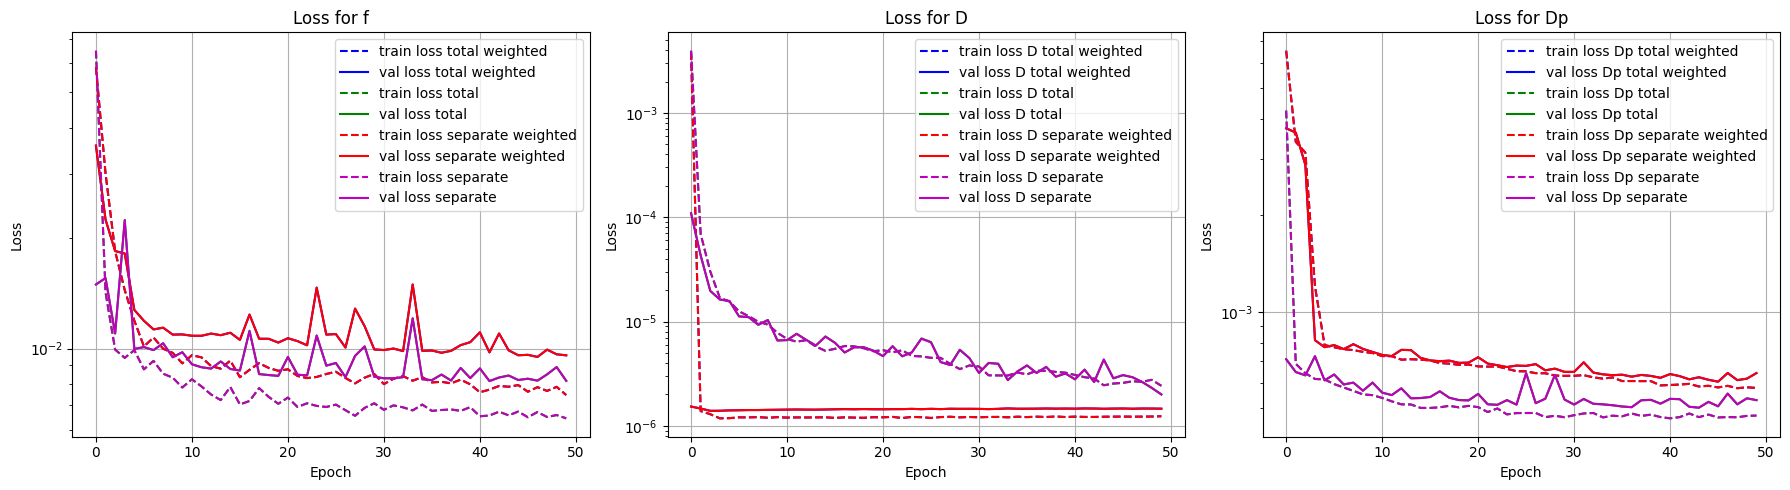

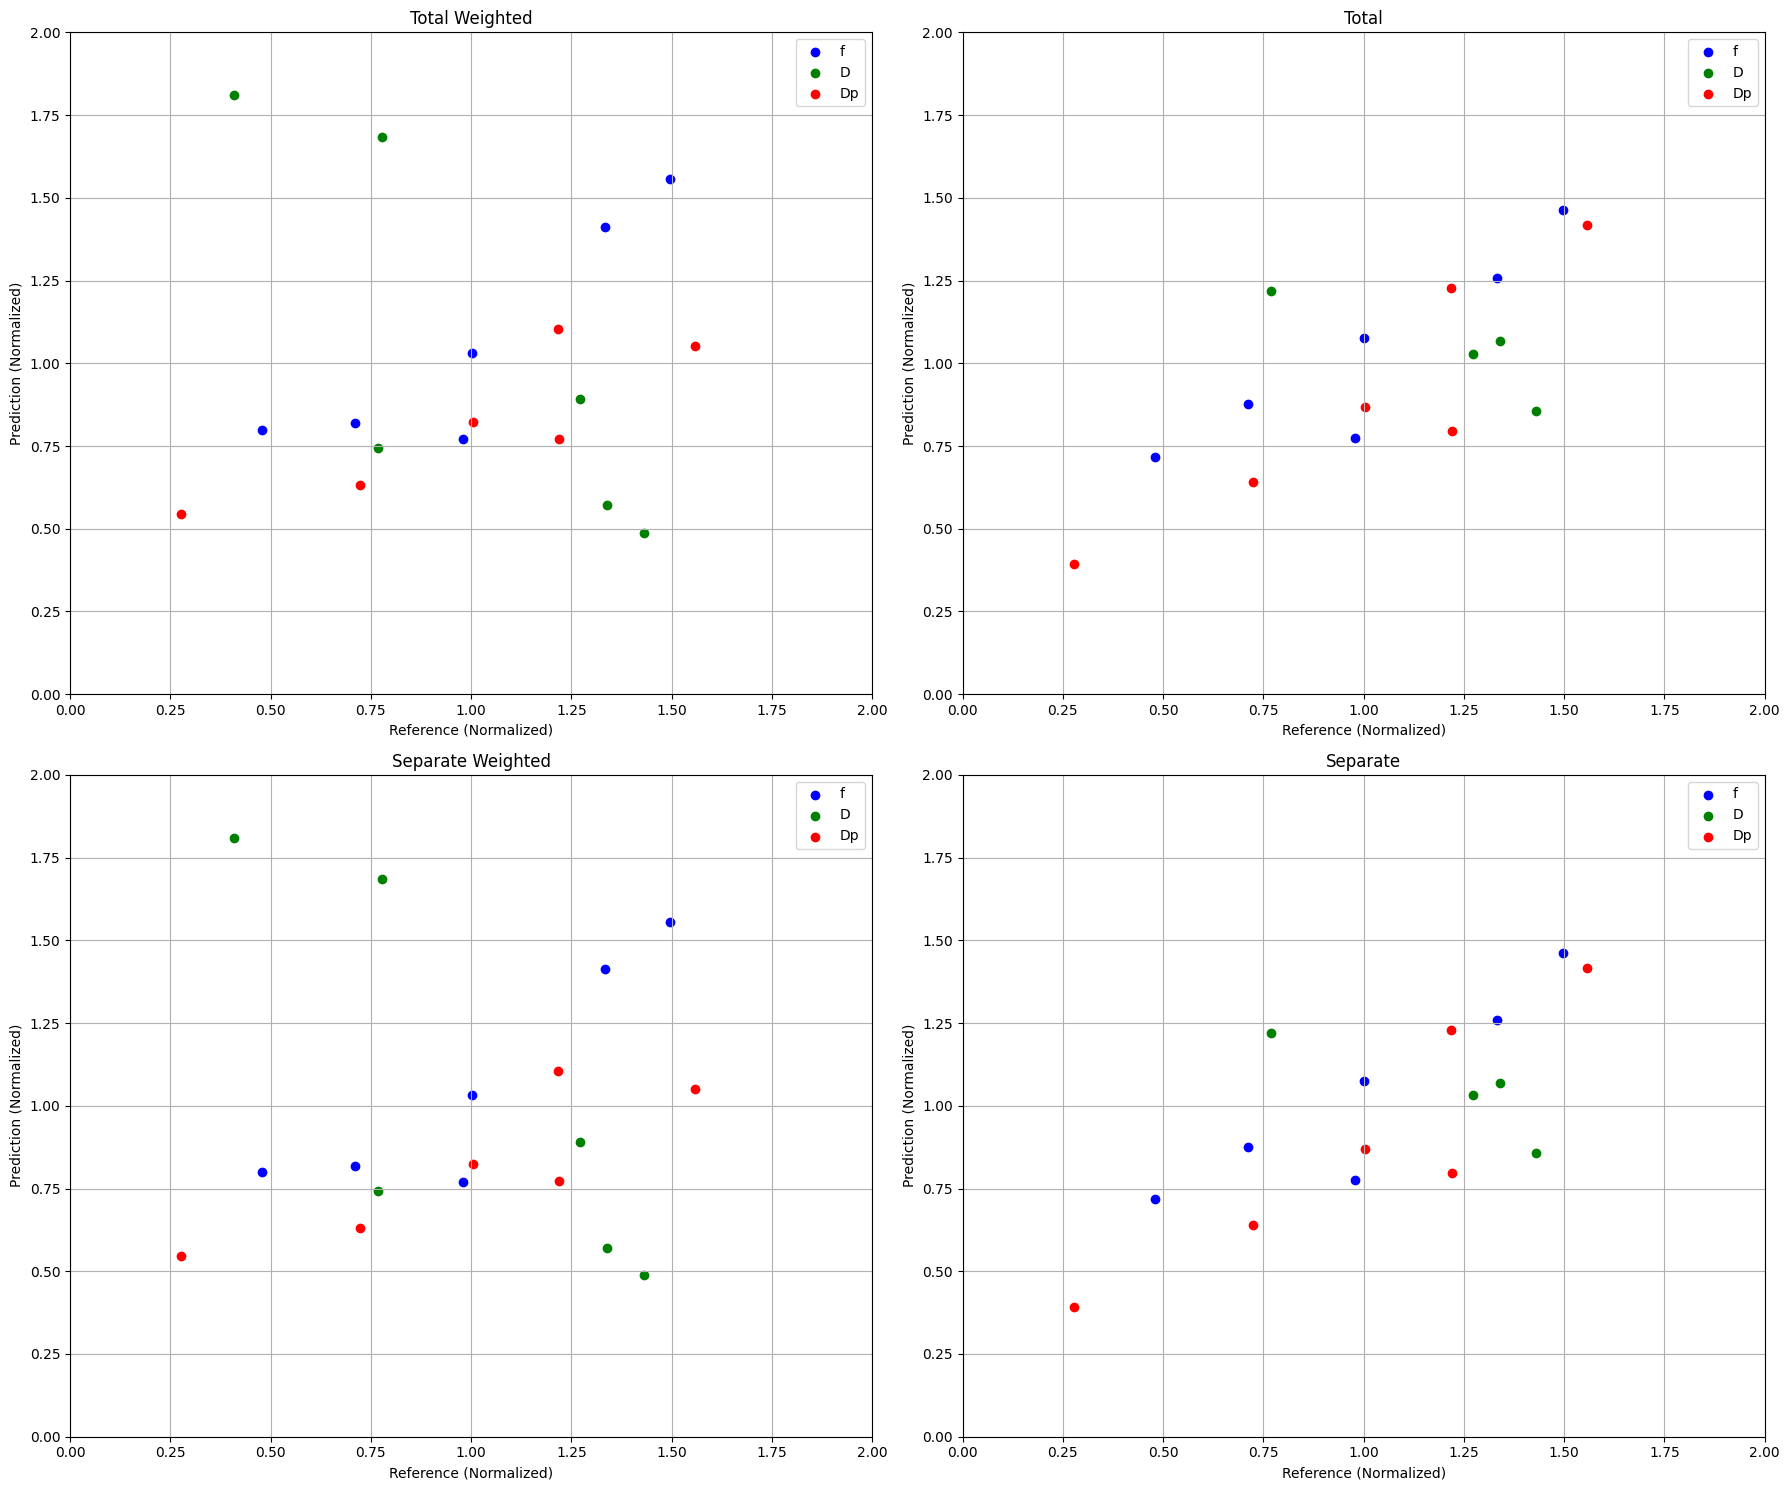

In [17]:
plot_data_tot_weigh, SD_test_tot_weigh, sys_test_tot_weigh, test_loss_tot_weigh = train_network('tot_weigh', optimizer='adagrad', activation_function='elu', do_D_Dp=True, output_scaling=False, sims=1000, epochs=50, hidden_width=30, hidden_layers=2, wandb_interval=1, loss_handling='total weighted')
plot_data_tot, SD_test_tot, sys_test_tot, test_loss_tot = train_network('tot', optimizer='adagrad', activation_function='elu', do_D_Dp=True, output_scaling=False, sims=1000, epochs=50, hidden_width=30, hidden_layers=2, wandb_interval=1, loss_handling='total')
plot_data_sep_weigh, SD_test_sep_weigh, sys_test_sep_weigh, test_loss_sep_weigh = train_network('sep_weigh', optimizer='adagrad', activation_function='elu', do_D_Dp=True, output_scaling=False, sims=1000, epochs=50, hidden_width=30, hidden_layers=2, wandb_interval=1, loss_handling='separate weighted')
plot_data_sep, SD_test_sep, sys_test_sep, test_loss_sep = train_network('sep', optimizer='adagrad', activation_function='elu', do_D_Dp=True, output_scaling=False, sims=1000, epochs=50, hidden_width=30, hidden_layers=2, wandb_interval=1, loss_handling='separate')



fig, axs = plt.subplots(1, 3, figsize=(18, 5))
# Plot for f
axs[0].semilogy(plot_data_tot_weigh["train_loss"], linestyle='--', color='b', label='train loss total weighted')
axs[0].semilogy(plot_data_tot_weigh["val_loss"], color='b', label='val loss total weighted')
axs[0].semilogy(plot_data_tot["train_loss"], linestyle='--', color='g', label='train loss total')
axs[0].semilogy(plot_data_tot["val_loss"], color='g', label='val loss total')
axs[0].semilogy(plot_data_sep_weigh["train_loss"], linestyle='--', color='r', label='train loss separate weighted')
axs[0].semilogy(plot_data_sep_weigh["val_loss"], color='r', label='val loss separate weighted')
axs[0].semilogy(plot_data_sep["train_loss"], linestyle='--', color='m', label='train loss separate')
axs[0].semilogy(plot_data_sep["val_loss"], color='m', label='val loss separate')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)
axs[0].set_title('Loss for f')


# Plot for D
axs[1].semilogy(plot_data_tot_weigh["train_loss_D"], linestyle='--', color='b', label='train loss D total weighted')
axs[1].semilogy(plot_data_tot_weigh["val_loss_D"], color='b', label='val loss D total weighted')
axs[1].semilogy(plot_data_tot["train_loss_D"], linestyle='--', color='g', label='train loss D total')
axs[1].semilogy(plot_data_tot["val_loss_D"], color='g', label='val loss D total')
axs[1].semilogy(plot_data_sep_weigh["train_loss_D"], linestyle='--', color='r', label='train loss D separate weighted')
axs[1].semilogy(plot_data_sep_weigh["val_loss_D"], color='r', label='val loss D separate weighted')
axs[1].semilogy(plot_data_sep["train_loss_D"], linestyle='--', color='m', label='train loss D separate')
axs[1].semilogy(plot_data_sep["val_loss_D"], color='m', label='val loss D separate')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)
axs[1].set_title('Loss for D')

# Plot for Dp
axs[2].semilogy(plot_data_tot_weigh["train_loss_Dp"], linestyle='--', color='b', label='train loss Dp total weighted')
axs[2].semilogy(plot_data_tot_weigh["val_loss_Dp"], color='b', label='val loss Dp total weighted')
axs[2].semilogy(plot_data_tot["train_loss_Dp"], linestyle='--', color='g', label='train loss Dp total')
axs[2].semilogy(plot_data_tot["val_loss_Dp"], color='g', label='val loss Dp total')
axs[2].semilogy(plot_data_sep_weigh["train_loss_Dp"], linestyle='--', color='r', label='train loss Dp separate weighted')
axs[2].semilogy(plot_data_sep_weigh["val_loss_Dp"], color='r', label='val loss Dp separate weighted')
axs[2].semilogy(plot_data_sep["train_loss_Dp"], linestyle='--', color='m', label='train loss Dp separate')
axs[2].semilogy(plot_data_sep["val_loss_Dp"], color='m', label='val loss Dp separate')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid(True)
axs[2].set_title('Loss for Dp')

plt.tight_layout()
plt.show()

# Calculate means for normalization
mean_f = np.mean(np.array(plot_data_tot_weigh["table_val_f"][-1])[:, 0])
mean_D = np.mean(np.array(plot_data_tot_weigh["table_val_D"][-1])[:, 0])
mean_Dp = np.mean(np.array(plot_data_tot_weigh["table_val_Dp"][-1])[:, 0])

fig, axs = plt.subplots(2, 2, figsize=(18, 15))

# Plot for total weighted
axs[0, 0].scatter(np.array(plot_data_tot_weigh["table_val_f"][-1])[:,0] / mean_f, np.array(plot_data_tot_weigh["table_val_f"][-1])[:,1] / mean_f, color='b', label='f')
axs[0, 0].scatter(np.array(plot_data_tot_weigh["table_val_D"][-1])[:,0] / mean_D, np.array(plot_data_tot_weigh["table_val_D"][-1])[:,1] / mean_D, color='g', label='D')
axs[0, 0].scatter(np.array(plot_data_tot_weigh["table_val_Dp"][-1])[:,0] / mean_Dp, np.array(plot_data_tot_weigh["table_val_Dp"][-1])[:,1] / mean_Dp, color='r', label='Dp')
axs[0, 0].set_xlabel('Reference (Normalized)')
axs[0, 0].set_ylabel('Prediction (Normalized)')
axs[0, 0].legend()
axs[0, 0].grid(True)
axs[0, 0].set_title('Total Weighted')
axs[0, 0].set_xlim([0, 2.5])
axs[0, 0].set_ylim([0, 2.5])

# Plot for total
axs[0, 1].scatter(np.array(plot_data_tot["table_val_f"][-1])[:,0] / mean_f, np.array(plot_data_tot["table_val_f"][-1])[:,1] / mean_f, color='b', label='f')
axs[0, 1].scatter(np.array(plot_data_tot["table_val_D"][-1])[:,0] / mean_D, np.array(plot_data_tot["table_val_D"][-1])[:,1] / mean_D, color='g', label='D')
axs[0, 1].scatter(np.array(plot_data_tot["table_val_Dp"][-1])[:,0] / mean_Dp, np.array(plot_data_tot["table_val_Dp"][-1])[:,1] / mean_Dp, color='r', label='Dp')
axs[0, 1].set_xlabel('Reference (Normalized)')
axs[0, 1].set_ylabel('Prediction (Normalized)')
axs[0, 1].legend()
axs[0, 1].grid(True)
axs[0, 1].set_title('Total')
axs[0, 1].set_xlim([0, 2.5])
axs[0, 1].set_ylim([0, 2.5])

# Plot for separate weighted
axs[1, 0].scatter(np.array(plot_data_sep_weigh["table_val_f"][-1])[:,0] / mean_f, np.array(plot_data_sep_weigh["table_val_f"][-1])[:,1] / mean_f, color='b', label='f')
axs[1, 0].scatter(np.array(plot_data_sep_weigh["table_val_D"][-1])[:,0] / mean_D, np.array(plot_data_sep_weigh["table_val_D"][-1])[:,1] / mean_D, color='g', label='D')
axs[1, 0].scatter(np.array(plot_data_sep_weigh["table_val_Dp"][-1])[:,0] / mean_Dp, np.array(plot_data_sep_weigh["table_val_Dp"][-1])[:,1] / mean_Dp, color='r', label='Dp')
axs[1, 0].set_xlabel('Reference (Normalized)')
axs[1, 0].set_ylabel('Prediction (Normalized)')
axs[1, 0].legend()
axs[1, 0].grid(True)
axs[1, 0].set_title('Separate Weighted')
axs[1, 0].set_xlim([0, 2.5])
axs[1, 0].set_ylim([0, 2.5])

# Plot for separate
axs[1, 1].scatter(np.array(plot_data_sep["table_val_f"][-1])[:,0] / mean_f, np.array(plot_data_sep["table_val_f"][-1])[:,1] / mean_f, color='b', label='f')
axs[1, 1].scatter(np.array(plot_data_sep["table_val_D"][-1])[:,0] / mean_D, np.array(plot_data_sep["table_val_D"][-1])[:,1] / mean_D, color='g', label='D')
axs[1, 1].scatter(np.array(plot_data_sep["table_val_Dp"][-1])[:,0] / mean_Dp, np.array(plot_data_sep["table_val_Dp"][-1])[:,1] / mean_Dp, color='r', label='Dp')
axs[1, 1].set_xlabel('Reference (Normalized)')
axs[1, 1].set_ylabel('Prediction (Normalized)')
axs[1, 1].legend()
axs[1, 1].grid(True)
axs[1, 1].set_title('Separate')
axs[1, 1].set_xlim([0, 2.5])
axs[1, 1].set_ylim([0, 2.5])

plt.tight_layout()
plt.show()

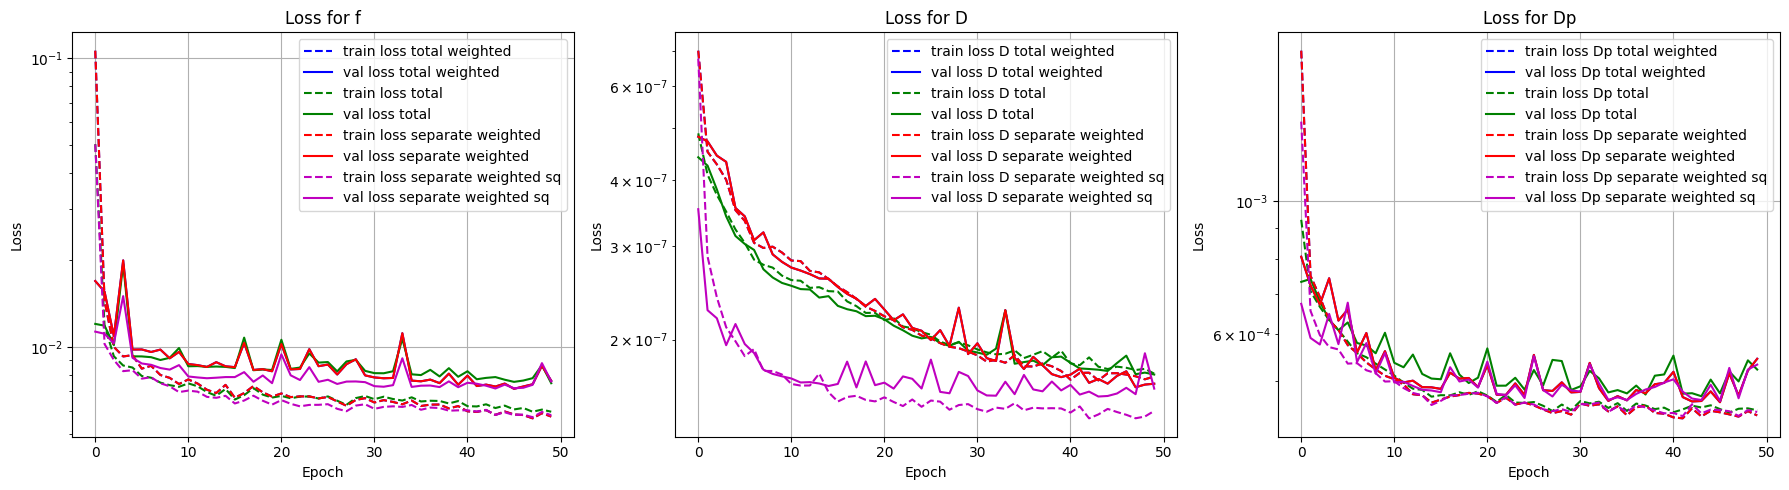

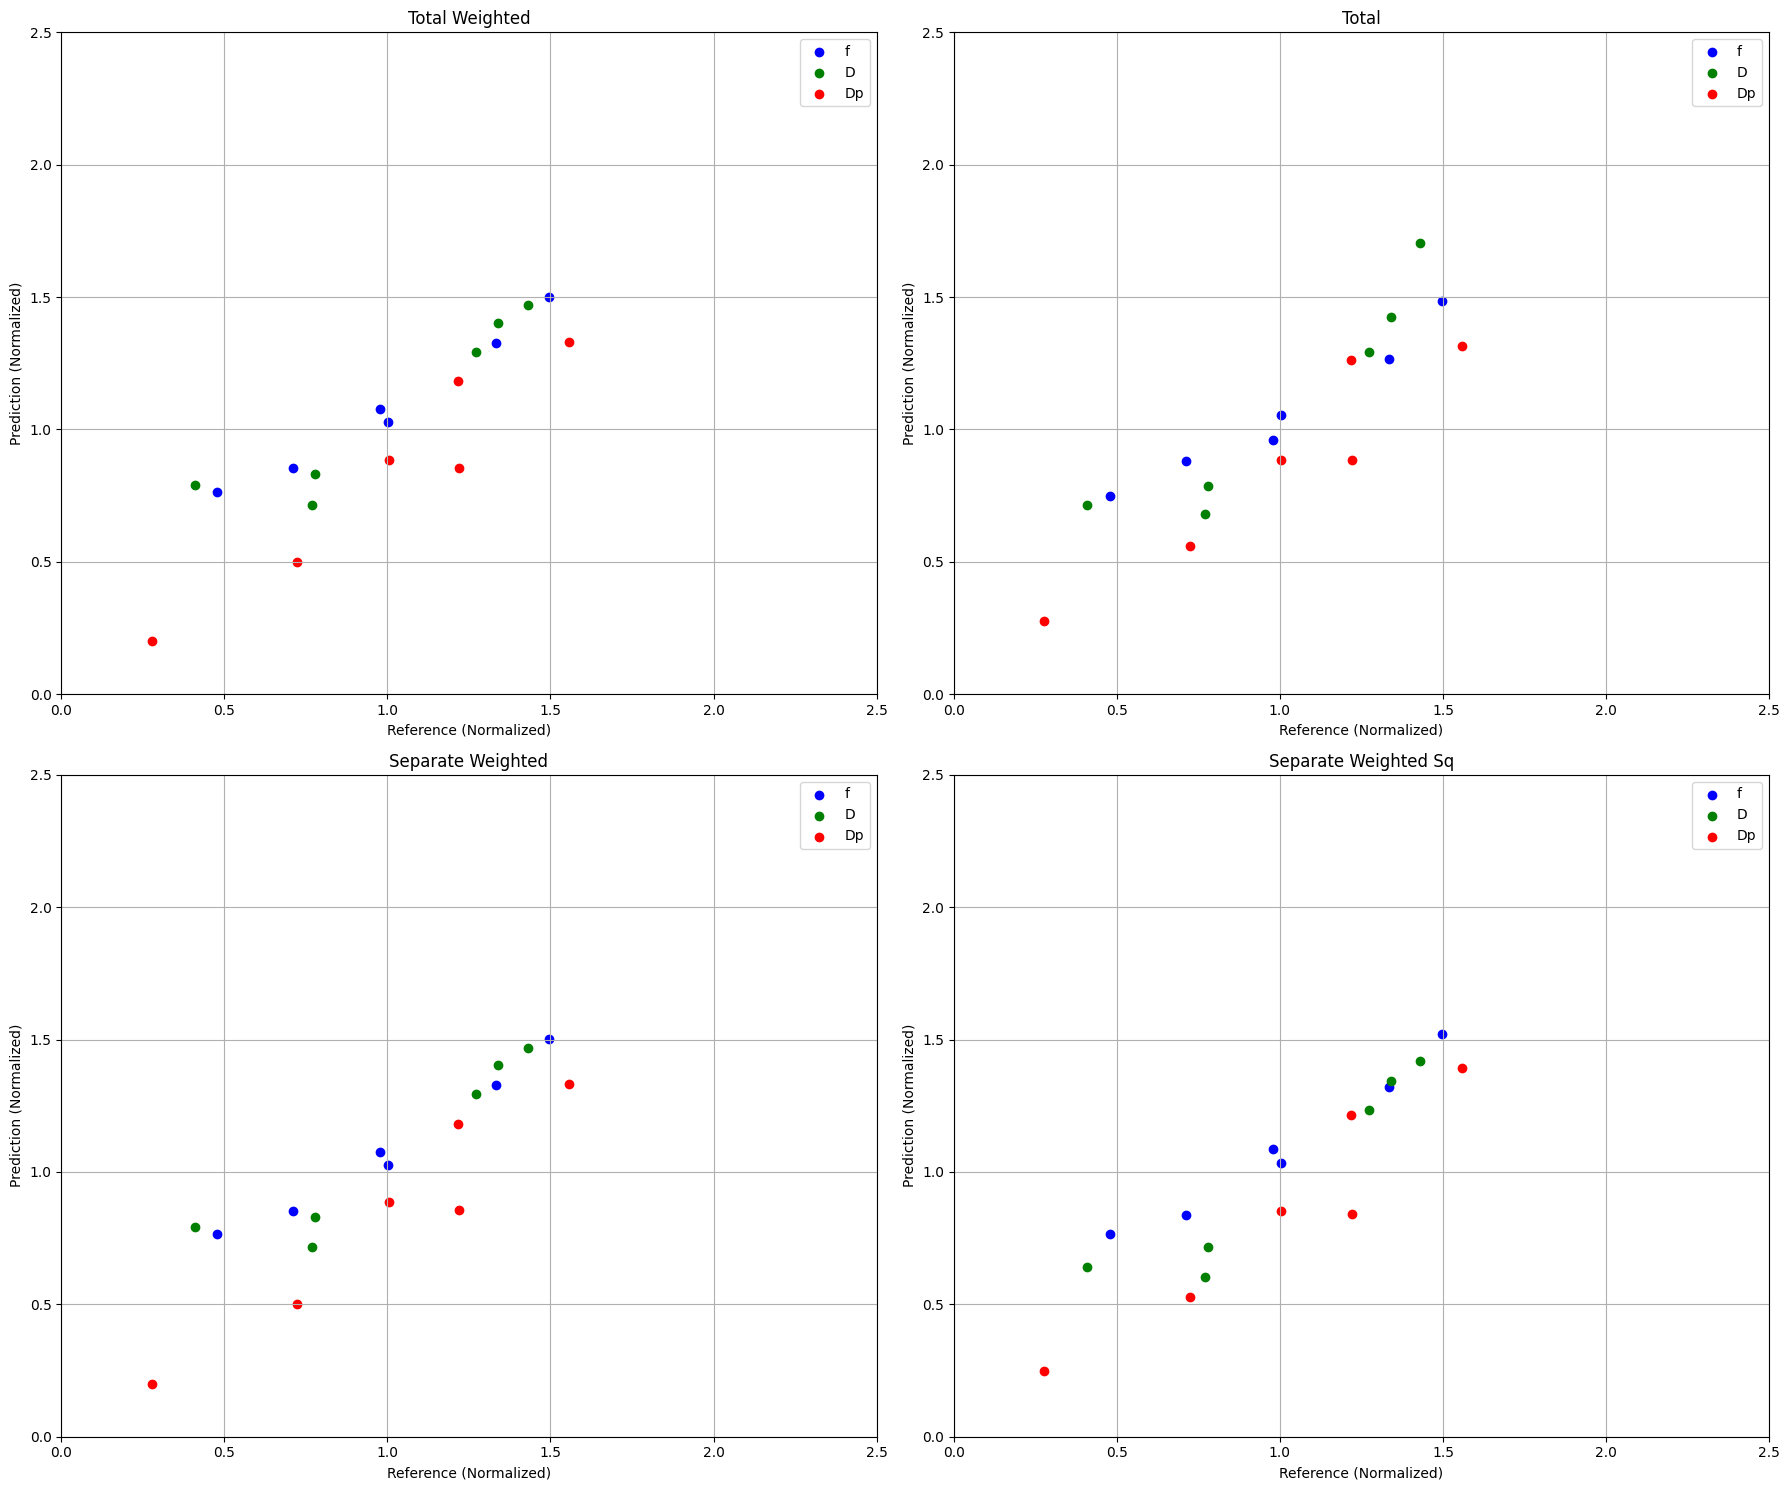

In [23]:
plot_data_tot_weigh_scaled, SD_test_tot_weigh_scaled, sys_test_tot_weigh_scaled, test_loss_tot_weigh_scaled = train_network('tot_weigh', optimizer='adagrad', activation_function='elu', do_D_Dp=True, output_scaling=True, sims=1000, epochs=50, hidden_width=30, hidden_layers=2, wandb_interval=1, loss_handling='total weighted')
plot_data_tot_scaled, SD_test_tot_scaled, sys_test_tot_scaled, test_loss_tot_scaled = train_network('tot', optimizer='adagrad', activation_function='elu', do_D_Dp=True, output_scaling=True, sims=1000, epochs=50, hidden_width=30, hidden_layers=2, wandb_interval=1, loss_handling='total')
plot_data_sep_weigh_scaled, SD_test_sep_weigh_scaled, sys_test_sep_weigh_scaled, test_loss_sep_weigh_scaled = train_network('sep_weigh', optimizer='adagrad', activation_function='elu', do_D_Dp=True, output_scaling=True, sims=1000, epochs=50, hidden_width=30, hidden_layers=2, wandb_interval=1, loss_handling='separate weighted')
plot_data_sep_scaled, SD_test_sep_scaled, sys_test_sep_scaled, test_loss_sep_scaled = train_network('sep', optimizer='adagrad', activation_function='elu', do_D_Dp=True, output_scaling=True, sims=1000, epochs=50, hidden_width=30, hidden_layers=2, wandb_interval=1, loss_handling='separate weighted sq')


fig, axs = plt.subplots(1, 3, figsize=(18, 5))
# Plot for f
axs[0].semilogy(plot_data_tot_weigh_scaled["train_loss"], linestyle='--', color='b', label='train loss total weighted')
axs[0].semilogy(plot_data_tot_weigh_scaled["val_loss"], color='b', label='val loss total weighted')
axs[0].semilogy(plot_data_tot_scaled["train_loss"], linestyle='--', color='g', label='train loss total')
axs[0].semilogy(plot_data_tot_scaled["val_loss"], color='g', label='val loss total')
axs[0].semilogy(plot_data_sep_weigh_scaled["train_loss"], linestyle='--', color='r', label='train loss separate weighted')
axs[0].semilogy(plot_data_sep_weigh_scaled["val_loss"], color='r', label='val loss separate weighted')
axs[0].semilogy(plot_data_sep_scaled["train_loss"], linestyle='--', color='m', label='train loss separate weighted sq')
axs[0].semilogy(plot_data_sep_scaled["val_loss"], color='m', label='val loss separate weighted sq')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)
axs[0].set_title('Loss for f')

# Plot for D
axs[1].semilogy(plot_data_tot_weigh_scaled["train_loss_D"], linestyle='--', color='b', label='train loss D total weighted')
axs[1].semilogy(plot_data_tot_weigh_scaled["val_loss_D"], color='b', label='val loss D total weighted')
axs[1].semilogy(plot_data_tot_scaled["train_loss_D"], linestyle='--', color='g', label='train loss D total')
axs[1].semilogy(plot_data_tot_scaled["val_loss_D"], color='g', label='val loss D total')
axs[1].semilogy(plot_data_sep_weigh_scaled["train_loss_D"], linestyle='--', color='r', label='train loss D separate weighted')
axs[1].semilogy(plot_data_sep_weigh_scaled["val_loss_D"], color='r', label='val loss D separate weighted')
axs[1].semilogy(plot_data_sep_scaled["train_loss_D"], linestyle='--', color='m', label='train loss D separate weighted sq')
axs[1].semilogy(plot_data_sep_scaled["val_loss_D"], color='m', label='val loss D separate weighted sq')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()
axs[1].grid(True)
axs[1].set_title('Loss for D')

# Plot for Dp
axs[2].semilogy(plot_data_tot_weigh_scaled["train_loss_Dp"], linestyle='--', color='b', label='train loss Dp total weighted')
axs[2].semilogy(plot_data_tot_weigh_scaled["val_loss_Dp"], color='b', label='val loss Dp total weighted')
axs[2].semilogy(plot_data_tot_scaled["train_loss_Dp"], linestyle='--', color='g', label='train loss Dp total')
axs[2].semilogy(plot_data_tot_scaled["val_loss_Dp"], color='g', label='val loss Dp total')
axs[2].semilogy(plot_data_sep_weigh_scaled["train_loss_Dp"], linestyle='--', color='r', label='train loss Dp separate weighted')
axs[2].semilogy(plot_data_sep_weigh_scaled["val_loss_Dp"], color='r', label='val loss Dp separate weighted')
axs[2].semilogy(plot_data_sep_scaled["train_loss_Dp"], linestyle='--', color='m', label='train loss Dp separate weighted sq')
axs[2].semilogy(plot_data_sep_scaled["val_loss_Dp"], color='m', label='val loss Dp separate weighted sq')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')
axs[2].legend()
axs[2].grid(True)
axs[2].set_title('Loss for Dp')

plt.tight_layout()
plt.show()


# Calculate means for normalization
mean_f = np.mean(np.array(plot_data_tot_weigh_scaled["table_val_f"][-1])[:, 0])
mean_D = np.mean(np.array(plot_data_tot_weigh_scaled["table_val_D"][-1])[:, 0])
mean_Dp = np.mean(np.array(plot_data_tot_weigh_scaled["table_val_Dp"][-1])[:, 0])

fig, axs = plt.subplots(2, 2, figsize=(18, 15))
# Plot for total weighted
axs[0, 0].scatter(np.array(plot_data_tot_weigh_scaled["table_val_f"][-1])[:,0] / mean_f, np.array(plot_data_tot_weigh_scaled["table_val_f"][-1])[:,1] / mean_f, color='b', label='f')
axs[0, 0].scatter(np.array(plot_data_tot_weigh_scaled["table_val_D"][-1])[:,0] / mean_D, np.array(plot_data_tot_weigh_scaled["table_val_D"][-1])[:,1] / mean_D, color='g', label='D')
axs[0, 0].scatter(np.array(plot_data_tot_weigh_scaled["table_val_Dp"][-1])[:,0] / mean_Dp, np.array(plot_data_tot_weigh_scaled["table_val_Dp"][-1])[:,1] / mean_Dp, color='r', label='Dp')
axs[0, 0].set_xlabel('Reference (Normalized)')
axs[0, 0].set_ylabel('Prediction (Normalized)')
axs[0, 0].legend()
axs[0, 0].grid(True)
axs[0, 0].set_title('Total Weighted')
axs[0, 0].set_xlim(0, 2.5)
axs[0, 0].set_ylim(0, 2.5)

# Plot for total
axs[0, 1].scatter(np.array(plot_data_tot_scaled["table_val_f"][-1])[:,0] / mean_f, np.array(plot_data_tot_scaled["table_val_f"][-1])[:,1] / mean_f, color='b', label='f')
axs[0, 1].scatter(np.array(plot_data_tot_scaled["table_val_D"][-1])[:,0] / mean_D, np.array(plot_data_tot_scaled["table_val_D"][-1])[:,1] / mean_D, color='g', label='D')
axs[0, 1].scatter(np.array(plot_data_tot_scaled["table_val_Dp"][-1])[:,0] / mean_Dp, np.array(plot_data_tot_scaled["table_val_Dp"][-1])[:,1] / mean_Dp, color='r', label='Dp')
axs[0, 1].set_xlabel('Reference (Normalized)')
axs[0, 1].set_ylabel('Prediction (Normalized)')
axs[0, 1].legend()
axs[0, 1].grid(True)
axs[0, 1].set_title('Total')
axs[0, 1].set_xlim(0, 2.5)
axs[0, 1].set_ylim(0, 2.5)

# Plot for separate weighted
axs[1, 0].scatter(np.array(plot_data_sep_weigh_scaled["table_val_f"][-1])[:,0] / mean_f, np.array(plot_data_sep_weigh_scaled["table_val_f"][-1])[:,1] / mean_f, color='b', label='f')
axs[1, 0].scatter(np.array(plot_data_sep_weigh_scaled["table_val_D"][-1])[:,0] / mean_D, np.array(plot_data_sep_weigh_scaled["table_val_D"][-1])[:,1] / mean_D, color='g', label='D')
axs[1, 0].scatter(np.array(plot_data_sep_weigh_scaled["table_val_Dp"][-1])[:,0] / mean_Dp, np.array(plot_data_sep_weigh_scaled["table_val_Dp"][-1])[:,1] / mean_Dp, color='r', label='Dp')
axs[1, 0].set_xlabel('Reference (Normalized)')
axs[1, 0].set_ylabel('Prediction (Normalized)')
axs[1, 0].legend()
axs[1, 0].grid(True)
axs[1, 0].set_title('Separate Weighted')
axs[1, 0].set_xlim(0, 2.5)
axs[1, 0].set_ylim(0, 2.5)

# Plot for separate weighted sq
axs[1, 1].scatter(np.array(plot_data_sep_scaled["table_val_f"][-1])[:,0] / mean_f, np.array(plot_data_sep_scaled["table_val_f"][-1])[:,1] / mean_f, color='b', label='f')
axs[1, 1].scatter(np.array(plot_data_sep_scaled["table_val_D"][-1])[:,0] / mean_D, np.array(plot_data_sep_scaled["table_val_D"][-1])[:,1] / mean_D, color='g', label='D')
axs[1, 1].scatter(np.array(plot_data_sep_scaled["table_val_Dp"][-1])[:,0] / mean_Dp, np.array(plot_data_sep_scaled["table_val_Dp"][-1])[:,1] / mean_Dp, color='r', label='Dp')
axs[1, 1].set_xlabel('Reference (Normalized)')
axs[1, 1].set_ylabel('Prediction (Normalized)')
axs[1, 1].legend()
axs[1, 1].grid(True)
axs[1, 1].set_title('Separate Weighted Sq')
axs[1, 1].set_xlim(0, 2.5)
axs[1, 1].set_ylim(0, 2.5)

plt.tight_layout()
plt.show()

# For scoring 7.5+
So far, you have been working with simulated data (taken care of by Data_loader.py). For such data, we know the ground truth values. However, in vivo, we have no way of knowing the ground truth. How will our network perform? Note that for this exercise you may need ot play with hyperparameters and design choices to train.

K.	Use the network, as trained in (J) and apply it to real-world data which is provided by running “dataval, valid_id, bvalues = hf.load_real_data(eval=True)”.
- You will need to export you trained network in the return of the "train_network" function
- you will need to apply it to the "dataval" from hf.load_real_data(eval=True)
- you will then want to put the outputs through "hf.plot_example(np.squeeze(D_out), valid_id,0.003)", "hf.plot_example(np.squeeze(f_out), valid_id,0.7)" and "hf.plot_example(np.squeeze(Dp_out), valid_id,0.1)", with the predicted D, f and Dp being D_out, f_out and Dp_out.

Note that alongside your plot (the first), also a conventional least squares fit is provided as a reference. Show the resulting parameter maps. How does your approach compare? Why do you think your particular approach would look better/worse?

L.	Ideally, you would train your network on real-world data. However, in this particular case, it is hard to get gold standard references. Luckily, we can use our understanding of physics, and of how stuff “should behave” to work our way around this. You will redesign your network loss, such that it can train on data without any gold standard references! Instead of placing the L2 loss on f_pred v.s. f_ref. Currently, the network is learning to minimize the difference between predicted fpred and the ground truth referene ftrue. In vivo, we may not have these references. To overcome this, we will now introduce a physics-informed loss. Use the IVIM equation [1] to propogate the predictions (D, f and Dp) into the signal space (S). Then, take e.g. the mean-square-error between the predicted signal and the input signal. Note that you will need to use torch functions (instead of numpy functions) to ensure you can backpropogate the loss through the equation into the network. You can train this network on the simulated data from earlier exercises. But it should also be able to train it on the in vivo data from "datatrain, bvalues = hf.load_real_data(eval=False)". This ensures that the network is use to looking at "real" data. Optimize the network’s training using the real data provided (“test_in_vivo.py”; datatrain). Evaluate the network on the same data as in 1 (data, valid_id, bvalues = dl.load_real_data(eval=True)). How does it perform?


## K) Real data

In [79]:
model = train_network('J', optimizer='adagrad', activation_function='elu', do_D_Dp=True, output_scaling=True, sims=100000, epochs=30, hidden_width=30, hidden_layers=2, wandb_interval=1, return_model=True)

Load patient data 

Patient data loaded

Load patient data 

Patient data loaded

training data is 103608 long


In [ ]:
dataval, valid_id, bvalues = hf.load_real_data(eval=True)


# append the data to the output arrays
f_out_t, D_out_t, Dp_out_t = model.forward(torch.tensor(dataval)).T
f_out = f_out_t.detach().numpy()
D_out = D_out_t.detach().numpy()
Dp_out = Dp_out_t.detach().numpy()
## then test your network using dataval.
''''if you manage to make predictions of D, f and Dp, the following code will allow you to plot them:'''

print("D")
hf.plot_example(np.squeeze(D_out), valid_id,0.003)
print("f")
hf.plot_example(np.squeeze(f_out), valid_id,0.7)
print("Dp")
hf.plot_example(np.squeeze(Dp_out), valid_id,0.1)
hf.plot_ref()

### you can compare supervised and self-supervised fits

Load patient data 

Patient data loaded



## L)

In [128]:
def train_network_unsupervised(name, epochs=200, learningrate=0.1, hidden_layers=2, hidden_width=5, optimizer='SGD', bvalues=bvalues, batch_size=16, activation_function='relu', output_scaling=False, wandb_interval=10, loss_handling='total weighted', return_model=False, training_data=None, validation_data=None, test_data = None):


    # get the data
    trainloader = torch.utils.data.DataLoader(training_data,
                            batch_size=batch_size,
                            shuffle=True,
                            drop_last=True)
    inferloader = torch.utils.data.DataLoader(validation_data,
                            batch_size=min(batch_size,len(validation_data)),
                            shuffle=False,
                            drop_last=False)


    # get the model
    model = make_model(n_inputs=len(bvalues), n_hidden=hidden_layers, hidden_width=hidden_width, n_outputs=3, activation_function=activation_function)
    D_mean, f_mean, Dp_mean = sim_dat_means(trainloader)

    # initialize model --> we did this above, but during the exercise, you might be re-running this part of the script several times with different settings. This way we make sure you re-initiate the training and don't continue in the last model
    model.apply(init_weights)

    # initialize wandb
    wandb.init(project="AI_for_medical_imaging", job_type="training", name=name)

    # set random seed for reproducibility
    torch.manual_seed(seed)

    # probe available devices
    if torch.cuda.is_available():  # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Set default device. If GPU is available, the network will be trained on the GPU. Note that further down in the code, stuff will be sent ".to(device)" to make sure it is available on the GPU.
    device = torch.device('cpu')#'cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # define the loss of the network (mean square error)
    loss_module = nn.MSELoss(reduction='mean').to(device)

    # the optimizer determines how strongly to update the network's weights based on the calculated loss.
    if optimizer == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learningrate)
    elif optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learningrate)
    elif optimizer == 'adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=learningrate)
    else:
        raise NotImplementedError('this optimizer is not implemented yet...')

    # initialize the plot data
    plot_data = {
        "train_loss": [],
        "val_loss": [],
        "SD_train": [],
        "SD_val": [],
        "sys_train": [],
        "sys_val": [],
        "table_train": [],
        "table_val": []
    }

    # loop over epochs
    for epoch in range(epochs):
        # initiate losses and errors to 0
        train_loss_S = 0
        val_loss_S = 0
        SD_train = 0
        sys_train = 0
        
        # set model to training such that forward passes are remembered (requiered for backpropogating the loss)
        model.train()

        # loop over all training data
        for x in trainloader:
            # reset the gradients to zero
            optimizer.zero_grad()
            # get data (x[0]) and put the data on the GPU if available
            batch = x[0].to(device)

            # put the data through the neural network
            f_pred, D_pred, Dp_pred = model.forward(batch).T
            if output_scaling: f_pred, D_pred, Dp_pred = f_pred, D_pred*3e-3+0.5e-3, Dp_pred*125e-3+5e-3

            # Signal equation
            S_pred = (1 - f_pred) * torch.exp(-torch.tensor(bvalues) * D_pred) + f_pred * torch.exp(-torch.tensor(bvalues) * Dp_pred)

            # calculate loss (compare predicted S to the input S)
            loss_S = loss_module(S_pred.double(), batch.double())

            #add found loss to the train loss, to keep track of the loss this epoch
            train_loss_S += loss_S.item()

            loss_S.backward()

            # update all weights according to their derrivatives to the loss.
            optimizer.step()
            # calculate the standard deviation and systematic error on the trianing data
            SD, sys = hf.error_metrics(S_pred.cpu().detach().numpy(), batch.cpu().detach().numpy())

            # add the errors to ultimately calculate their mean over the training data. calculating mean SDs goes via the Root Mean Squares. So add SDs squared
            SD_train += SD**2
            sys_train += sys

        # now divide by the total amount of training data to calculate the mean (sys error) and square of mean (SD).
        SD_train = np.sqrt(SD_train/trainloader.__len__())
        sys_train = sys_train/trainloader.__len__()

        #make b-value data pairs: Note these currently contain the f_ref and f_pred from the trianing data. You may want to swap to validation data once implemented
        example_data=[[x,y] for (x,y) in zip(batch.cpu().detach().numpy(),S_pred.cpu().detach().numpy())]

        
        # after training, set model to evaluation mode
        model.eval()
        
        if not return_model or return_model == 'all':

            ######################your code here for validation loss#########################

            # initialize error_metrics
            SD_val = 0
            sys_val = 0

            for x in inferloader:
                # get data (x[0]) and put the data on the GPU if available
                batch = x[0].to(device)

                # put the data through the neural network
                f_pred, D_pred, Dp_pred = model.forward(batch).T
                if output_scaling: f_pred, D_pred, Dp_pred = f_pred, D_pred*3e-3+0.5e-3, Dp_pred*125e-3+5e-3

                # Signal equation
                S_pred = (1 - f_pred) * torch.exp(-torch.tensor(bvalues) * D_pred) + f_pred * torch.exp(-torch.tensor(bvalues) * Dp_pred)

                # calculate loss (compare predicted S to the input S)
                loss_S = loss_module(S_pred.double(), batch.double())

                #add found loss to the train loss, to keep track of the loss this epoch
                val_loss_S += loss_S.item()

                # calculate the standard deviation and systematic error on the validation data
                SD, sys = hf.error_metrics(S_pred.cpu().detach().numpy(),batch.cpu().detach().numpy())

                # add the errors to ultimately calculate their mean over the validation data. calculating mean SDs goes via the Root Mean Squares. So add SDs squared
                SD_val += SD**2
                sys_val += sys

            #make b-value data pairs: Note these currently contain the f_ref and f_pred from the trianing data. You may want to swap to validation data once implemented
            example_data_val=[[x,y] for (x,y) in zip(batch.cpu().detach().numpy(),S_pred.cpu().detach().numpy())]
        

            # now divide by the total amount of training data to calculate the mean (sys error) and square of mean (SD).
            SD_val = np.sqrt(SD_val/inferloader.__len__())
            sys_val = sys_val/inferloader.__len__()

            # put it in a table
            table = wandb.Table(data=example_data, columns=["f_ref", "f_pred"])

            # tell wandb to plot the table for the validation data
            table_val = wandb.Table(data=example_data_val, columns=["f_ref", "f_pred"])

            #tell wandb to plot the table
            # note that some parameters are being logged which you still need to define in the validation loop!
            if epoch % wandb_interval == 0:
                wandb.log({"loss/train": train_loss_S/trainloader.__len__(),
                "loss/val": val_loss_S/inferloader.__len__(),
                "error/random error": SD_train,
                "error/systematic error": sys_train,
                "Training Data (Epoch " + str(epoch) + ")": wandb.plot.scatter(table, "f_ref", "f_pred", title=f'Training Data f (Epoch {epoch})'),
                "Validation Data (Epoch " + str(epoch) + ")": wandb.plot.scatter(table_val, "f_ref", "f_pred", title=f'Validation Data f (Epoch {epoch})')})


            # add the data to the plot_data dictionary
            plot_data["train_loss"].append(train_loss_S/trainloader.__len__())
            plot_data["val_loss"].append(val_loss_S/inferloader.__len__())
            plot_data["SD_train"].append(SD_train)
            plot_data["SD_val"].append(SD_val)  
            plot_data["sys_train"].append(sys_train)
            plot_data["sys_val"].append(sys_val)
            plot_data["table_train"].append(example_data)
            plot_data["table_val"].append(example_data_val)



            ## print output in terminal. Only useful for debugging when WandB does not work
            #print('epoch = ' + str(epoch) + ' train loss =' + str(train_loss_f/trainloader.__len__()) +' val loss =' + str(val_loss_f/inferloader.__len__()) + 'the systematic error is ' + str(sys_val) + ' and the random error is ' + str(SD_val))

    wandb.finish()
    
    if return_model == 'all':
        return plot_data, model
    elif not return_model:
        return plot_data
    else:
        return model

In [129]:
datatrain, bvalues = hf.load_real_data(eval=False)
print('training data is ' + str(len(datatrain)) + ' long')

### use datatrain to train your network.
model = train_network_unsupervised('L', optimizer='adagrad', activation_function='elu', output_scaling=True, epochs=30, hidden_width=30, hidden_layers=2, wandb_interval=1, return_model='all', training_data=datatrain, validation_data= dataval ,bvalues=bvalues)


Load patient data 

Patient data loaded

training data is 103608 long


In [131]:
plot_data, model = model

Load patient data 

Patient data loaded

D
Load patient data 



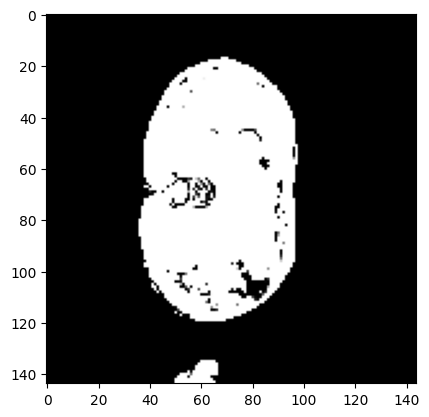

f
Load patient data 



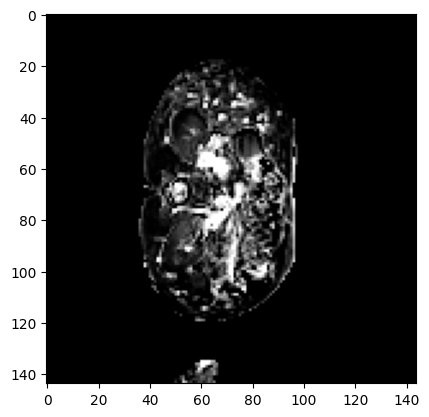

Dp
Load patient data 



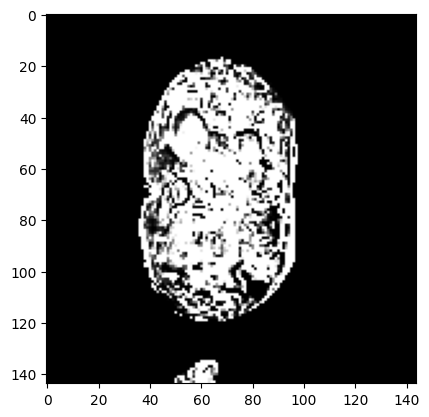

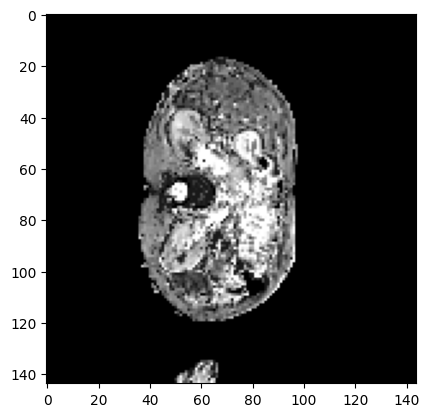

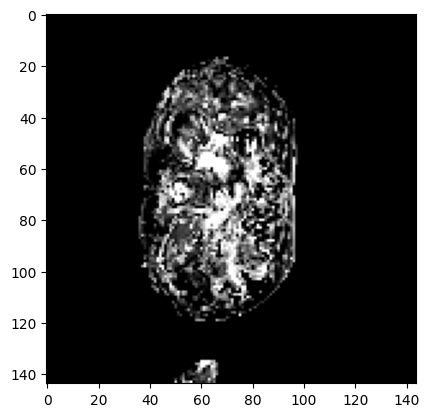

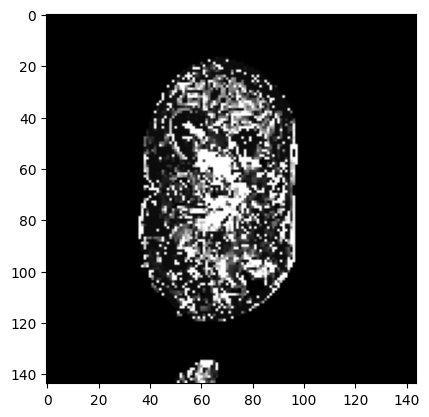

In [132]:


dataval, valid_id, bvalues = hf.load_real_data(eval=True)


# append the data to the output arrays
f_out_t, D_out_t, Dp_out_t = model.forward(torch.tensor(dataval)).T
f_out = f_out_t.detach().numpy()
D_out = D_out_t.detach().numpy()
Dp_out = Dp_out_t.detach().numpy()
## then test your network using dataval.
''''if you manage to make predictions of D, f and Dp, the following code will allow you to plot them:'''

print("D")
hf.plot_example(np.squeeze(D_out), valid_id,0.003)
print("f")
hf.plot_example(np.squeeze(f_out), valid_id,0.7)
print("Dp")
hf.plot_example(np.squeeze(Dp_out), valid_id,0.1)
hf.plot_ref()

### you can compare supervised and self-supervised fits